# Design CTP-14 human genome DNA-MERFISH library 

by Pu Zheng

2022.10.14


# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0'></a>
# 0 Minimum required packages and settings

<a id='0.1'></a>
## 0.1 load required packages

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

44820


<a id='1'></a>
# 1 Extract region sequences

In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [4]:
resolution = 0
flanking = 10000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_genome_library')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports


<a id='1.1'></a>
## 1.1 select regions

In [29]:
# prepare sequence reader
reload(ia.library_tools.sequences)
seq_rd = ia.library_tools.sequences.sequence_reader(genome_folder)
seq_rd.load_ref_sequences() # load genomic sequences

-- load sequence: 1, size=248956422
-- load sequence: 10, size=133797422
-- load sequence: 11, size=135086622
-- load sequence: 12, size=133275309
-- load sequence: 13, size=114364328
-- load sequence: 14, size=107043718
-- load sequence: 15, size=101991189
-- load sequence: 16, size=90338345
-- load sequence: 17, size=83257441
-- load sequence: 18, size=80373285
-- load sequence: 19, size=58617616
-- load sequence: 2, size=242193529
-- load sequence: 20, size=64444167
-- load sequence: 21, size=46709983
-- load sequence: 22, size=50818468
-- load sequence: 3, size=198295559
-- load sequence: 4, size=190214555
-- load sequence: 5, size=181538259
-- load sequence: 6, size=170805979
-- load sequence: 7, size=159345973
-- load sequence: 8, size=145138636
-- load sequence: 9, size=138394717
-- load sequence: MT, size=16569
-- load sequence: X, size=156040895
-- load sequence: Y, size=57227415
-- load sequence: KI270728.1, size=1872759
-- load sequence: KI270727.1, size=448248
-- load seque

In [31]:
# calculate total length
min_chr_len = 2000000 # ONLY taking care of chromosomes longer than 1Mb
chr_len_dict = {_name:len(_record) for _name, _record in seq_rd.ref_seq_dict.items() if len(_record) > min_chr_len}
total_len = sum(list(chr_len_dict.values()))
print(total_len)

3088269832


## select resolution for each chromosome

In [45]:
overwrite = False
region_num_filename = os.path.join(library_folder, 'chr_2_design_region_num.pkl')
resolution_filename = os.path.join(library_folder, 'chr_2_design_resolution.pkl')

# if both files exists, directly load
if os.path.exists(region_num_filename) and os.path.exists(resolution_filename) and not overwrite:
    print(f"Loading from file: {region_num_filename}")
    chr_2_region_num = pickle.load(open(region_num_filename, 'rb'))
    print(f"Loading from file: {resolution_filename}")
    chr_2_resolution = pickle.load(open(resolution_filename, 'rb'))
else:
    # Selecte regions in an adaptive manner to gaurentee 
    allowed_resolutions = (np.arange(25,0,-5) * 1e5).astype(np.int32)
    min_chr_region_num = 40
    chr_2_region_num = {}
    chr_2_resolution = {}
    for _name, _len in sorted(chr_len_dict.items(), key=lambda v:v[1]): 
        # iterative
        for _resolution in allowed_resolutions:
            # select the shortest chromosome first
            _curr_num = np.floor(_len/_resolution).astype(np.int32)
            if _curr_num >= min_chr_region_num:
                chr_2_region_num[_name] = _curr_num
                chr_2_resolution[_name] = _resolution
                print(_name, _resolution, _curr_num)
                min_chr_region_num = max(_curr_num * 0.8, min_chr_region_num)
                break    
    print(np.sum(list(chr_2_region_num.values())))
    # save
    print(f"Saving to file: {region_num_filename}")
    pickle.dump(chr_2_region_num, open(region_num_filename, 'wb'))
    print(f"Saving to file: {resolution_filename}")
    pickle.dump(chr_2_resolution, open(resolution_filename, 'wb'))

Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_design_region_num.pkl
Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_design_resolution.pkl


## For each chromosome, calculate region center:

In [46]:
from ImageAnalysis3.structure_tools.distance import sort_chr
region_size = 30000 # extract 30kb around the targets

In [47]:
region_dict_savefile = os.path.join(sequence_folder, 'region_dicts.pkl')
if os.path.exists(region_dict_savefile) and not overwrite:
    print(f"Loading from file: {region_dict_savefile}")
    region_dicts = pickle.load(open(region_dict_savefile, 'rb'))
else:
    region_seqs = []
    region_dicts = []
    region_id = 0
    for _chr in sorted(chr_2_region_num.keys(), key=lambda _v:sort_chr(_v)):
        print(_chr)
        _region_num = chr_2_region_num[_chr]
        _resolution = chr_2_resolution[_chr]
        # get region center
        _reg_centers = (np.arange(0.5,_region_num+0.5, 1) * _resolution ).astype(np.int32)
        _reg_starts = _reg_centers - int(region_size/2) + 1
        _reg_ends = _reg_centers + int(region_size/2)
        _seqs = [seq_rd.ref_seq_dict[_chr][_s:_e] for _s,_e in zip(_reg_starts, _reg_ends)]
        region_seqs.extend(_seqs)

        for _s,_e in zip(_reg_starts, _reg_ends):
            _reg_dict = {
                'Chr':_chr,
                'Start':_s,
                'End':_e,
                'Region':f"{_chr}:{_s}-{_e}",
                'Strand':'+',
                'Gene': region_id,
            }
            region_dicts.append(_reg_dict)
            region_id += 1
    # save
    print(f"Saving to file: {region_dict_savefile}")
    pickle.dump(region_dicts, open(region_dict_savefile, 'wb'))

Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\region_dicts.pkl


In [48]:
seqs = seq_rd.find_sequence_for_region(region_dicts)

-- searching among 24 references
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a m

In [49]:
seq_rd.save_sequences(save_folder=sequence_folder)

-- saving sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\0_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\2_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\3_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\4_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\5_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Librarie

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\87_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\88_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\89_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\90_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\91_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\92_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\93_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Lib

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\181_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\182_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\183_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\184_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\185_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\186_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\187_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\273_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\274_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\275_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\276_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\277_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\278_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\279_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\363_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\364_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\365_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\366_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\367_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\368_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\369_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\455_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\456_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\457_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\458_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\459_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\460_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\461_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\518_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\519_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\520_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\521_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\522_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\523_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\524_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\605_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\606_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\607_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\608_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\609_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\610_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\611_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\684_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\685_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\686_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\687_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\688_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\689_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\690_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\766_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\767_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\768_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\769_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\770_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\771_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\772_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\850_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\851_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\852_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\853_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\854_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\855_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\856_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\958_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\959_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\960_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\961_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\962_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\963_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\964_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1021_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1022_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1023_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1024_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1025_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1026_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1027_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1083_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1084_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1085_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1086_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1087_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1088_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1089_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1146_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1147_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1148_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1149_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1150_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1151_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1152_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1209_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1210_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1211_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1212_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1213_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1214_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1215_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1304_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1305_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1306_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1307_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1308_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1309_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1310_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1397_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1398_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1399_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1400_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1401_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1402_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1403_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1497_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1498_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1499_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1500_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1501_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1502_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1503_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires hg38 genome

In [50]:
overwrite_table = False

### construct map for whole genome

In [51]:
from ImageAnalysis3 import library_tools

In [52]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'hg38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {genome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_genome_17w.npy already exist, skip.


### construct map for transcriptome

In [53]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {transcriptome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_transcriptome_17w.npy already exist, skip.


### construct map for repeats from RepBase

In [54]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {repeat_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Repbase_v2603_repeat_17w.npy already exist, skip.


<a id='2.2'></a>
## 2.2 Design probes

In [55]:
from ImageAnalysis3 import library_tools
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'hg38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
probe_savefile = os.path.join(report_folder, f'merged_probes.pbr')
print(probe_savefile)

1579 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr


### create pb_designer class

In [57]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=probe_savefile,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 25, # 14
               #'ref_merfish': 14,
               'gc':[0.25,0.75],'tm': 37+0.62*50+5,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 1579
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr

- Fail to load from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr, file doesn't exist.


False

### calculate probe reports

In [58]:
%%time
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 117.838s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 121.144s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 111.222s.
Time(s): 350.2070834636688
- Designing targeting sequence for 1579 regions
-- designing region: 1:1235001-1265000_strand_+_gene_0 -- region: 0, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\0_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.308s.
- Designed 59918 candidate probes in 16.210s.
-- designing region: 1:3735001-3765000_strand_+_gene_1 -- region: 1, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.343s.
- Designed 59918 candidate probes in 23.067s.

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.444s.
-- designing region: 1:58735001-58765000_strand_+_gene_23 -- region: 23, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\23_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.575s.
-- designing region: 1:61235001-61265000_strand_+_gene_24 -- region: 24, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\24_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.401s.
-- designing region: 1:63735001-63765000_strand_+_gene_25 -- region: 25, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\25_reg_0.fasta
-

- Designed 59918 candidate probes in 15.656s.
-- designing region: 1:116235001-116265000_strand_+_gene_46 -- region: 46, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\46_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.691s.
-- designing region: 1:118735001-118765000_strand_+_gene_47 -- region: 47, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\47_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.892s.
-- designing region: 1:121235001-121265000_strand_+_gene_48 -- region: 48, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\48_reg_0.fasta
-- setting attribute: map_self_seque

--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.318s.
-- designing region: 1:176235001-176265000_strand_+_gene_70 -- region: 70, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\70_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 1:178735001-178765000_strand_+_gene_71 -- region: 71, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\71_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.554s.
-- designing region: 1:181235001-181265000_strand_+_gene_72 -- region: 72, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\72_reg_0.f

--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.578s.
-- designing region: 1:233735001-233765000_strand_+_gene_93 -- region: 93, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\93_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.612s.
-- designing region: 1:236235001-236265000_strand_+_gene_94 -- region: 94, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\94_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 1:238735001-238765000_strand_+_gene_95 -- region: 95, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\95_reg_0.f

--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.440s.
-- designing region: 2:43735001-43765000_strand_+_gene_116 -- region: 116, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\116_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.455s.
-- designing region: 2:46235001-46265000_strand_+_gene_117 -- region: 117, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\117_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.493s.
-- designing region: 2:48735001-48765000_strand_+_gene_118 -- region: 118, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\118_reg_

--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.558s.
-- designing region: 2:101235001-101265000_strand_+_gene_139 -- region: 139, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\139_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 25.058s.
-- designing region: 2:103735001-103765000_strand_+_gene_140 -- region: 140, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\140_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.551s.
-- designing region: 2:106235001-106265000_strand_+_gene_141 -- region: 141, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\14

--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 2:158735001-158765000_strand_+_gene_162 -- region: 162, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\162_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 2:161235001-161265000_strand_+_gene_163 -- region: 163, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\163_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.503s.
-- designing region: 2:163735001-163765000_strand_+_gene_164 -- region: 164, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\16

--- finish map_self_sequences in 0.301s.
- Designed 59918 candidate probes in 15.456s.
-- designing region: 2:216235001-216265000_strand_+_gene_185 -- region: 185, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\185_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.542s.
-- designing region: 2:218735001-218765000_strand_+_gene_186 -- region: 186, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\186_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.507s.
-- designing region: 2:221235001-221265000_strand_+_gene_187 -- region: 187, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\18

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.554s.
-- designing region: 3:33735001-33765000_strand_+_gene_208 -- region: 208, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\208_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.509s.
-- designing region: 3:36235001-36265000_strand_+_gene_209 -- region: 209, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\209_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 3:38735001-38765000_strand_+_gene_210 -- region: 210, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\210_reg_

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.578s.
-- designing region: 3:91235001-91265000_strand_+_gene_231 -- region: 231, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\231_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.236s.
- Designed 41860 candidate probes in 11.001s.
-- designing region: 3:93735001-93765000_strand_+_gene_232 -- region: 232, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\232_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 3:96235001-96265000_strand_+_gene_233 -- region: 233, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\233_reg_

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.646s.
-- designing region: 3:148735001-148765000_strand_+_gene_254 -- region: 254, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\254_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 3:151235001-151265000_strand_+_gene_255 -- region: 255, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\255_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 31.099s.
-- designing region: 3:153735001-153765000_strand_+_gene_256 -- region: 256, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\25

--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.686s.
-- designing region: 4:8735001-8765000_strand_+_gene_277 -- region: 277, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\277_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.580s.
-- designing region: 4:11235001-11265000_strand_+_gene_278 -- region: 278, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\278_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.828s.
-- designing region: 4:13735001-13765000_strand_+_gene_279 -- region: 279, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\279_reg_0.

--- finish map_self_sequences in 0.300s.
- Designed 59918 candidate probes in 15.596s.
-- designing region: 4:66235001-66265000_strand_+_gene_300 -- region: 300, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\300_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.594s.
-- designing region: 4:68735001-68765000_strand_+_gene_301 -- region: 301, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\301_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 4:71235001-71265000_strand_+_gene_302 -- region: 302, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\302_reg_

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.596s.
-- designing region: 4:123735001-123765000_strand_+_gene_323 -- region: 323, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\323_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.582s.
-- designing region: 4:126235001-126265000_strand_+_gene_324 -- region: 324, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\324_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.529s.
-- designing region: 4:128735001-128765000_strand_+_gene_325 -- region: 325, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\32

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.595s.
-- designing region: 4:181235001-181265000_strand_+_gene_346 -- region: 346, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\346_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.591s.
-- designing region: 4:183735001-183765000_strand_+_gene_347 -- region: 347, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\347_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.671s.
-- designing region: 4:186235001-186265000_strand_+_gene_348 -- region: 348, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\34

--- finish map_self_sequences in 0.259s.
- Designed 59918 candidate probes in 15.511s.
-- designing region: 5:48735001-48765000_strand_+_gene_369 -- region: 369, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\369_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
- Designed 59918 candidate probes in 15.364s.
-- designing region: 5:51235001-51265000_strand_+_gene_370 -- region: 370, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\370_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.486s.
-- designing region: 5:53735001-53765000_strand_+_gene_371 -- region: 371, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\371_reg_

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 5:106235001-106265000_strand_+_gene_392 -- region: 392, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\392_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 5:108735001-108765000_strand_+_gene_393 -- region: 393, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\393_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 18.066s.
-- designing region: 5:111235001-111265000_strand_+_gene_394 -- region: 394, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\39

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.552s.
-- designing region: 5:163735001-163765000_strand_+_gene_415 -- region: 415, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\415_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.598s.
-- designing region: 5:166235001-166265000_strand_+_gene_416 -- region: 416, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\416_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 5:168735001-168765000_strand_+_gene_417 -- region: 417, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\41

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.623s.
-- designing region: 6:41235001-41265000_strand_+_gene_438 -- region: 438, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\438_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.562s.
-- designing region: 6:43735001-43765000_strand_+_gene_439 -- region: 439, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\439_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.552s.
-- designing region: 6:46235001-46265000_strand_+_gene_440 -- region: 440, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\440_reg_

--- finish map_self_sequences in 0.649s.
- Designed 59918 candidate probes in 19.907s.
-- designing region: 6:98735001-98765000_strand_+_gene_461 -- region: 461, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\461_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.553s.
-- designing region: 6:101235001-101265000_strand_+_gene_462 -- region: 462, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\462_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.630s.
-- designing region: 6:103735001-103765000_strand_+_gene_463 -- region: 463, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\463_

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.689s.
-- designing region: 6:156235001-156265000_strand_+_gene_484 -- region: 484, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\484_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.621s.
-- designing region: 6:158735001-158765000_strand_+_gene_485 -- region: 485, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\485_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.632s.
-- designing region: 6:161235001-161265000_strand_+_gene_486 -- region: 486, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\48

--- finish map_self_sequences in 0.304s.
- Designed 59918 candidate probes in 15.604s.
-- designing region: 7:43735001-43765000_strand_+_gene_507 -- region: 507, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\507_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.493s.
-- designing region: 7:46235001-46265000_strand_+_gene_508 -- region: 508, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\508_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.489s.
-- designing region: 7:48735001-48765000_strand_+_gene_509 -- region: 509, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\509_reg_

--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.651s.
-- designing region: 7:101235001-101265000_strand_+_gene_530 -- region: 530, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\530_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 7:103735001-103765000_strand_+_gene_531 -- region: 531, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\531_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.653s.
-- designing region: 7:106235001-106265000_strand_+_gene_532 -- region: 532, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\53

--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.675s.
-- designing region: 8:1235001-1265000_strand_+_gene_553 -- region: 553, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\553_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.251s.
- Designed 59918 candidate probes in 15.478s.
-- designing region: 8:3735001-3765000_strand_+_gene_554 -- region: 554, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\554_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.537s.
-- designing region: 8:6235001-6265000_strand_+_gene_555 -- region: 555, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\555_reg_0.fast

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 8:58735001-58765000_strand_+_gene_576 -- region: 576, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\576_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.637s.
-- designing region: 8:61235001-61265000_strand_+_gene_577 -- region: 577, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\577_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.574s.
-- designing region: 8:63735001-63765000_strand_+_gene_578 -- region: 578, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\578_reg_

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.585s.
-- designing region: 8:116235001-116265000_strand_+_gene_599 -- region: 599, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\599_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.688s.
-- designing region: 8:118735001-118765000_strand_+_gene_600 -- region: 600, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\600_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 8:121235001-121265000_strand_+_gene_601 -- region: 601, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\60

--- finish map_self_sequences in 0.272s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 9:22985001-23015000_strand_+_gene_622 -- region: 622, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\622_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.302s.
- Designed 59918 candidate probes in 15.580s.
-- designing region: 9:24985001-25015000_strand_+_gene_623 -- region: 623, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\623_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.266s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 9:26985001-27015000_strand_+_gene_624 -- region: 624, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\624_reg_

--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.545s.
-- designing region: 9:68985001-69015000_strand_+_gene_645 -- region: 645, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\645_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.264s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 9:70985001-71015000_strand_+_gene_646 -- region: 646, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\646_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.547s.
-- designing region: 9:72985001-73015000_strand_+_gene_647 -- region: 647, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\647_reg_

--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.618s.
-- designing region: 9:114985001-115015000_strand_+_gene_668 -- region: 668, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\668_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.570s.
-- designing region: 9:116985001-117015000_strand_+_gene_669 -- region: 669, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\669_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 9:118985001-119015000_strand_+_gene_670 -- region: 670, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\67

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.621s.
-- designing region: 10:22985001-23015000_strand_+_gene_691 -- region: 691, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\691_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 10:24985001-25015000_strand_+_gene_692 -- region: 692, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\692_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.588s.
-- designing region: 10:26985001-27015000_strand_+_gene_693 -- region: 693, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\693_r

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.644s.
-- designing region: 10:68985001-69015000_strand_+_gene_714 -- region: 714, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\714_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 10:70985001-71015000_strand_+_gene_715 -- region: 715, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\715_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.727s.
-- designing region: 10:72985001-73015000_strand_+_gene_716 -- region: 716, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\716_r

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.651s.
-- designing region: 10:114985001-115015000_strand_+_gene_737 -- region: 737, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\737_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.595s.
-- designing region: 10:116985001-117015000_strand_+_gene_738 -- region: 738, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\738_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.600s.
-- designing region: 10:118985001-119015000_strand_+_gene_739 -- region: 739, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.533s.
-- designing region: 11:28985001-29015000_strand_+_gene_760 -- region: 760, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\760_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 11:30985001-31015000_strand_+_gene_761 -- region: 761, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\761_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.268s.
- Designed 59918 candidate probes in 15.505s.
-- designing region: 11:32985001-33015000_strand_+_gene_762 -- region: 762, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\762_r

--- finish map_self_sequences in 0.640s.
- Designed 59918 candidate probes in 16.006s.
-- designing region: 11:74985001-75015000_strand_+_gene_783 -- region: 783, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\783_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.635s.
-- designing region: 11:76985001-77015000_strand_+_gene_784 -- region: 784, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\784_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.297s.
- Designed 59918 candidate probes in 15.678s.
-- designing region: 11:78985001-79015000_strand_+_gene_785 -- region: 785, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\785_r

--- finish map_self_sequences in 0.270s.
- Designed 59918 candidate probes in 15.591s.
-- designing region: 11:120985001-121015000_strand_+_gene_806 -- region: 806, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\806_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.566s.
-- designing region: 11:122985001-123015000_strand_+_gene_807 -- region: 807, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\807_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 11:124985001-125015000_strand_+_gene_808 -- region: 808, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.270s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 12:32985001-33015000_strand_+_gene_829 -- region: 829, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\829_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.526s.
-- designing region: 12:34985001-35015000_strand_+_gene_830 -- region: 830, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\830_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.217s.
- Designed 59918 candidate probes in 15.718s.
-- designing region: 12:36985001-37015000_strand_+_gene_831 -- region: 831, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\831_r

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.604s.
-- designing region: 12:78985001-79015000_strand_+_gene_852 -- region: 852, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\852_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.573s.
-- designing region: 12:80985001-81015000_strand_+_gene_853 -- region: 853, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\853_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.586s.
-- designing region: 12:82985001-83015000_strand_+_gene_854 -- region: 854, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\854_r

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.601s.
-- designing region: 12:124985001-125015000_strand_+_gene_875 -- region: 875, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\875_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 12:126985001-127015000_strand_+_gene_876 -- region: 876, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\876_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.571s.
-- designing region: 12:128985001-129015000_strand_+_gene_877 -- region: 877, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.440s.
-- designing region: 13:38985001-39015000_strand_+_gene_898 -- region: 898, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\898_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.462s.
-- designing region: 13:40985001-41015000_strand_+_gene_899 -- region: 899, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\899_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.437s.
-- designing region: 13:42985001-43015000_strand_+_gene_900 -- region: 900, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\900_r

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.545s.
-- designing region: 13:84985001-85015000_strand_+_gene_921 -- region: 921, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\921_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 13:86985001-87015000_strand_+_gene_922 -- region: 922, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\922_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 13:88985001-89015000_strand_+_gene_923 -- region: 923, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\923_r

--- finish map_self_sequences in 0.549s.
- Designed 0 candidate probes in 0.842s.
-- designing region: 14:12735001-12765000_strand_+_gene_944 -- region: 944, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\944_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.574s.
- Designed 0 candidate probes in 0.868s.
-- designing region: 14:14235001-14265000_strand_+_gene_945 -- region: 945, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\945_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.557s.
- Designed 0 candidate probes in 0.850s.
-- designing region: 14:15735001-15765000_strand_+_gene_946 -- region: 946, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\946_reg_0.fasta
-- s

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.417s.
-- designing region: 14:47235001-47265000_strand_+_gene_967 -- region: 967, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\967_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.412s.
-- designing region: 14:48735001-48765000_strand_+_gene_968 -- region: 968, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\968_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.461s.
-- designing region: 14:50235001-50265000_strand_+_gene_969 -- region: 969, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\969_r

--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.594s.
-- designing region: 14:81735001-81765000_strand_+_gene_990 -- region: 990, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\990_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.603s.
-- designing region: 14:83235001-83265000_strand_+_gene_991 -- region: 991, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\991_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 14:84735001-84765000_strand_+_gene_992 -- region: 992, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\992_r

--- finish map_self_sequences in 0.560s.
- Designed 0 candidate probes in 0.854s.
-- designing region: 15:9735001-9765000_strand_+_gene_1013 -- region: 1013, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1013_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.553s.
- Designed 0 candidate probes in 0.846s.
-- designing region: 15:11235001-11265000_strand_+_gene_1014 -- region: 1014, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1014_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.559s.
- Designed 0 candidate probes in 0.853s.
-- designing region: 15:12735001-12765000_strand_+_gene_1015 -- region: 1015, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1015_reg_0.fas

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.428s.
-- designing region: 15:44235001-44265000_strand_+_gene_1036 -- region: 1036, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1036_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.444s.
-- designing region: 15:45735001-45765000_strand_+_gene_1037 -- region: 1037, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1037_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.448s.
-- designing region: 15:47235001-47265000_strand_+_gene_1038 -- region: 1038, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 15:78735001-78765000_strand_+_gene_1059 -- region: 1059, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1059_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 15:80235001-80265000_strand_+_gene_1060 -- region: 1060, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1060_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.620s.
-- designing region: 15:81735001-81765000_strand_+_gene_1061 -- region: 1061, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.346s.
-- designing region: 16:12735001-12765000_strand_+_gene_1082 -- region: 1082, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1082_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.394s.
-- designing region: 16:14235001-14265000_strand_+_gene_1083 -- region: 1083, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1083_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.407s.
-- designing region: 16:15735001-15765000_strand_+_gene_1084 -- region: 1084, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.564s.
- Designed 0 candidate probes in 0.859s.
-- designing region: 16:47235001-47265000_strand_+_gene_1105 -- region: 1105, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1105_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.620s.
- Designed 59918 candidate probes in 15.649s.
-- designing region: 16:48735001-48765000_strand_+_gene_1106 -- region: 1106, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1106_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.455s.
-- designing region: 16:50235001-50265000_strand_+_gene_1107 -- region: 1107, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\11

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.587s.
-- designing region: 16:81735001-81765000_strand_+_gene_1128 -- region: 1128, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1128_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.652s.
-- designing region: 16:83235001-83265000_strand_+_gene_1129 -- region: 1129, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1129_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 16:84735001-84765000_strand_+_gene_1130 -- region: 1130, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.220s.
- Designed 59918 candidate probes in 15.215s.
-- designing region: 17:26235001-26265000_strand_+_gene_1151 -- region: 1151, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1151_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.223s.
- Designed 59918 candidate probes in 15.257s.
-- designing region: 17:27735001-27765000_strand_+_gene_1152 -- region: 1152, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1152_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.364s.
-- designing region: 17:29235001-29265000_strand_+_gene_1153 -- region: 1153, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.583s.
- Designed 59918 candidate probes in 21.880s.
-- designing region: 17:60735001-60765000_strand_+_gene_1174 -- region: 1174, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1174_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.522s.
-- designing region: 17:62235001-62265000_strand_+_gene_1175 -- region: 1175, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1175_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 17:63735001-63765000_strand_+_gene_1176 -- region: 1176, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.727s.
-- designing region: 18:12735001-12765000_strand_+_gene_1197 -- region: 1197, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1197_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.272s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 18:14235001-14265000_strand_+_gene_1198 -- region: 1198, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1198_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 18:15735001-15765000_strand_+_gene_1199 -- region: 1199, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.459s.
-- designing region: 18:47235001-47265000_strand_+_gene_1220 -- region: 1220, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1220_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.451s.
-- designing region: 18:48735001-48765000_strand_+_gene_1221 -- region: 1221, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1221_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.489s.
-- designing region: 18:50235001-50265000_strand_+_gene_1222 -- region: 1222, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 19:1485001-1515000_strand_+_gene_1243 -- region: 1243, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1243_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.613s.
-- designing region: 19:2485001-2515000_strand_+_gene_1244 -- region: 1244, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1244_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 19:3485001-3515000_strand_+_gene_1245 -- region: 1245, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\124

--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.504s.
-- designing region: 19:24485001-24515000_strand_+_gene_1266 -- region: 1266, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1266_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.224s.
- Designed 31958 candidate probes in 8.605s.
-- designing region: 19:25485001-25515000_strand_+_gene_1267 -- region: 1267, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1267_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.221s.
- Designed 59918 candidate probes in 15.242s.
-- designing region: 19:26485001-26515000_strand_+_gene_1268 -- region: 1268, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequence

--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.450s.
-- designing region: 19:47485001-47515000_strand_+_gene_1289 -- region: 1289, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1289_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.539s.
-- designing region: 19:48485001-48515000_strand_+_gene_1290 -- region: 1290, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1290_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.534s.
-- designing region: 19:49485001-49515000_strand_+_gene_1291 -- region: 1291, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.600s.
-- designing region: 20:12485001-12515000_strand_+_gene_1312 -- region: 1312, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1312_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.630s.
-- designing region: 20:13485001-13515000_strand_+_gene_1313 -- region: 1313, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1313_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.672s.
-- designing region: 20:14485001-14515000_strand_+_gene_1314 -- region: 1314, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.429s.
-- designing region: 20:35485001-35515000_strand_+_gene_1335 -- region: 1335, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1335_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.265s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 20:36485001-36515000_strand_+_gene_1336 -- region: 1336, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1336_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.500s.
-- designing region: 20:37485001-37515000_strand_+_gene_1337 -- region: 1337, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.721s.
-- designing region: 20:58485001-58515000_strand_+_gene_1358 -- region: 1358, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1358_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.737s.
-- designing region: 20:59485001-59515000_strand_+_gene_1359 -- region: 1359, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1359_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.686s.
-- designing region: 20:60485001-60515000_strand_+_gene_1360 -- region: 1360, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.620s.
-- designing region: 21:17485001-17515000_strand_+_gene_1381 -- region: 1381, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1381_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.679s.
-- designing region: 21:18485001-18515000_strand_+_gene_1382 -- region: 1382, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1382_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.654s.
-- designing region: 21:19485001-19515000_strand_+_gene_1383 -- region: 1383, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.506s.
-- designing region: 21:40485001-40515000_strand_+_gene_1404 -- region: 1404, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1404_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.479s.
-- designing region: 21:41485001-41515000_strand_+_gene_1405 -- region: 1405, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1405_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.269s.
- Designed 59918 candidate probes in 15.511s.
-- designing region: 21:42485001-42515000_strand_+_gene_1406 -- region: 1406, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.476s.
-- designing region: 22:17485001-17515000_strand_+_gene_1427 -- region: 1427, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1427_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 22:18485001-18515000_strand_+_gene_1428 -- region: 1428, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1428_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.483s.
-- designing region: 22:19485001-19515000_strand_+_gene_1429 -- region: 1429, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.674s.
-- designing region: 22:40485001-40515000_strand_+_gene_1450 -- region: 1450, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1450_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 16.330s.
-- designing region: 22:41485001-41515000_strand_+_gene_1451 -- region: 1451, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1451_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.632s.
-- designing region: 22:42485001-42515000_strand_+_gene_1452 -- region: 1452, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.497s.
-- designing region: X:33735001-33765000_strand_+_gene_1473 -- region: 1473, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1473_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.499s.
-- designing region: X:36235001-36265000_strand_+_gene_1474 -- region: 1474, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1474_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.509s.
-- designing region: X:38735001-38765000_strand_+_gene_1475 -- region: 1475, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.488s.
-- designing region: X:91235001-91265000_strand_+_gene_1496 -- region: 1496, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1496_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 20.020s.
-- designing region: X:93735001-93765000_strand_+_gene_1497 -- region: 1497, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1497_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.622s.
- Designed 59918 candidate probes in 22.269s.
-- designing region: X:96235001-96265000_strand_+_gene_1498 -- region: 1498, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.862s.
-- designing region: X:148735001-148765000_strand_+_gene_1519 -- region: 1519, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1519_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.243s.
- Designed 59918 candidate probes in 16.043s.
-- designing region: X:151235001-151265000_strand_+_gene_1520 -- region: 1520, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1520_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.940s.
-- designing region: X:153735001-153765000_strand_+_gene_1521 -- region: 1521, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequ

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.506s.
-- designing region: Y:20485001-20515000_strand_+_gene_1542 -- region: 1542, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1542_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.500s.
-- designing region: Y:21485001-21515000_strand_+_gene_1543 -- region: 1543, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1543_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.535s.
-- designing region: Y:22485001-22515000_strand_+_gene_1544 -- region: 1544, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.559s.
- Designed 0 candidate probes in 0.854s.
-- designing region: Y:43485001-43515000_strand_+_gene_1565 -- region: 1565, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1565_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.551s.
- Designed 0 candidate probes in 0.846s.
-- designing region: Y:44485001-44515000_strand_+_gene_1566 -- region: 1566, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1566_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.558s.
- Designed 0 candidate probes in 0.851s.
-- designing region: Y:45485001-45515000_strand_+_gene_1567 -- region: 1567, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1567_reg_0.fast

### check probes

In [59]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 1:1235001-1265000_strand_+_gene_0, 57068 candidate probes
--- 19930 probes passed check_dic selection.
finish in 1.719s, 344 probes kept.
-- check region:1 1:3735001-3765000_strand_+_gene_1, 57548 candidate probes
--- 17833 probes passed check_dic selection.
finish in 1.605s, 319 probes kept.
-- check region:2 1:6235001-6265000_strand_+_gene_2, 58584 candidate probes
--- 24326 probes passed check_dic selection.
finish in 1.832s, 377 probes kept.
-- check region:3 1:8735001-8765000_strand_+_gene_3, 58690 candidate probes
--- 12490 probes passed check_dic selection.
finish in 1.391s, 242 probes kept.
-- check region:4 1:11235001-11265000_strand_+_gene_4, 55772 candidate probes
--- 15903 probes passed check_dic selection.
finish in 1.482s, 256 probes kept.
-- check region:5 1:13735001-13765000_strand_+_gene_5, 58958 candidate probes
--- 16480 probes passed check_dic selection.
finish in 1.511s, 303 probes kept.
-- check region:6 1:16235001-16265000_strand_+_gene_6, 57896

-- check region:52 1:131235001-131265000_strand_+_gene_52, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:53 1:133735001-133765000_strand_+_gene_53, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:54 1:136235001-136265000_strand_+_gene_54, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:55 1:138735001-138765000_strand_+_gene_55, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:56 1:141235001-141265000_strand_+_gene_56, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:57 1:143735001-143765000_strand_+_gene_57, 57134 candidate probes
--- 1466 probes passed check_dic selection.
finish in 0.973s, 60 probes kept.
-- check region:58 1:146235001-146265000_strand_+_gene_58, 57912 candidate probe

--- 8477 probes passed check_dic selection.
finish in 1.215s, 205 probes kept.
-- check region:104 2:13735001-13765000_strand_+_gene_104, 52880 candidate probes
--- 3896 probes passed check_dic selection.
finish in 0.969s, 119 probes kept.
-- check region:105 2:16235001-16265000_strand_+_gene_105, 59376 candidate probes
--- 23556 probes passed check_dic selection.
finish in 1.818s, 352 probes kept.
-- check region:106 2:18735001-18765000_strand_+_gene_106, 57758 candidate probes
--- 13112 probes passed check_dic selection.
finish in 1.377s, 244 probes kept.
-- check region:107 2:21235001-21265000_strand_+_gene_107, 58946 candidate probes
--- 19363 probes passed check_dic selection.
finish in 1.624s, 305 probes kept.
-- check region:108 2:23735001-23765000_strand_+_gene_108, 53196 candidate probes
--- 9170 probes passed check_dic selection.
finish in 1.173s, 213 probes kept.
-- check region:109 2:26235001-26265000_strand_+_gene_109, 57444 candidate probes
--- 10774 probes passed check_d

--- 16035 probes passed check_dic selection.
finish in 1.518s, 283 probes kept.
-- check region:155 2:141235001-141265000_strand_+_gene_155, 59734 candidate probes
--- 11963 probes passed check_dic selection.
finish in 1.351s, 252 probes kept.
-- check region:156 2:143735001-143765000_strand_+_gene_156, 59532 candidate probes
--- 17151 probes passed check_dic selection.
finish in 1.552s, 292 probes kept.
-- check region:157 2:146235001-146265000_strand_+_gene_157, 59104 candidate probes
--- 11906 probes passed check_dic selection.
finish in 1.345s, 255 probes kept.
-- check region:158 2:148735001-148765000_strand_+_gene_158, 59332 candidate probes
--- 10875 probes passed check_dic selection.
finish in 1.304s, 227 probes kept.
-- check region:159 2:151235001-151265000_strand_+_gene_159, 57610 candidate probes
--- 12441 probes passed check_dic selection.
finish in 1.362s, 231 probes kept.
-- check region:160 2:153735001-153765000_strand_+_gene_160, 59614 candidate probes
--- 5641 probes 

-- check region:205 3:26235001-26265000_strand_+_gene_205, 53482 candidate probes
--- 12872 probes passed check_dic selection.
finish in 1.297s, 241 probes kept.
-- check region:206 3:28735001-28765000_strand_+_gene_206, 59384 candidate probes
--- 14205 probes passed check_dic selection.
finish in 1.451s, 262 probes kept.
-- check region:207 3:31235001-31265000_strand_+_gene_207, 59732 candidate probes
--- 18090 probes passed check_dic selection.
finish in 1.596s, 324 probes kept.
-- check region:208 3:33735001-33765000_strand_+_gene_208, 56604 candidate probes
--- 8194 probes passed check_dic selection.
finish in 1.188s, 174 probes kept.
-- check region:209 3:36235001-36265000_strand_+_gene_209, 55888 candidate probes
--- 8315 probes passed check_dic selection.
finish in 1.174s, 180 probes kept.
-- check region:210 3:38735001-38765000_strand_+_gene_210, 59248 candidate probes
--- 23150 probes passed check_dic selection.
finish in 1.814s, 365 probes kept.
-- check region:211 3:41235001

--- 12065 probes passed check_dic selection.
finish in 1.245s, 225 probes kept.
-- check region:256 3:153735001-153765000_strand_+_gene_256, 58366 candidate probes
--- 11123 probes passed check_dic selection.
finish in 1.316s, 218 probes kept.
-- check region:257 3:156235001-156265000_strand_+_gene_257, 59370 candidate probes
--- 17780 probes passed check_dic selection.
finish in 1.580s, 288 probes kept.
-- check region:258 3:158735001-158765000_strand_+_gene_258, 57960 candidate probes
--- 17467 probes passed check_dic selection.
finish in 1.574s, 314 probes kept.
-- check region:259 3:161235001-161265000_strand_+_gene_259, 59342 candidate probes
--- 6225 probes passed check_dic selection.
finish in 1.142s, 160 probes kept.
-- check region:260 3:163735001-163765000_strand_+_gene_260, 56448 candidate probes
--- 7752 probes passed check_dic selection.
finish in 1.147s, 162 probes kept.
-- check region:261 3:166235001-166265000_strand_+_gene_261, 59188 candidate probes
--- 6472 probes pa

--- 12242 probes passed check_dic selection.
finish in 1.355s, 242 probes kept.
-- check region:307 4:83735001-83765000_strand_+_gene_307, 59474 candidate probes
--- 11535 probes passed check_dic selection.
finish in 1.342s, 231 probes kept.
-- check region:308 4:86235001-86265000_strand_+_gene_308, 52754 candidate probes
--- 10618 probes passed check_dic selection.
finish in 1.207s, 203 probes kept.
-- check region:309 4:88735001-88765000_strand_+_gene_309, 58880 candidate probes
--- 18640 probes passed check_dic selection.
finish in 1.613s, 343 probes kept.
-- check region:310 4:91235001-91265000_strand_+_gene_310, 55942 candidate probes
--- 6910 probes passed check_dic selection.
finish in 1.112s, 166 probes kept.
-- check region:311 4:93735001-93765000_strand_+_gene_311, 59373 candidate probes
--- 13572 probes passed check_dic selection.
finish in 1.411s, 267 probes kept.
-- check region:312 4:96235001-96265000_strand_+_gene_312, 59822 candidate probes
--- 11560 probes passed check

-- check region:357 5:18735001-18765000_strand_+_gene_357, 59204 candidate probes
--- 7013 probes passed check_dic selection.
finish in 1.180s, 170 probes kept.
-- check region:358 5:21235001-21265000_strand_+_gene_358, 58456 candidate probes
--- 9329 probes passed check_dic selection.
finish in 1.248s, 216 probes kept.
-- check region:359 5:23735001-23765000_strand_+_gene_359, 58770 candidate probes
--- 8580 probes passed check_dic selection.
finish in 1.214s, 179 probes kept.
-- check region:360 5:26235001-26265000_strand_+_gene_360, 59062 candidate probes
--- 8788 probes passed check_dic selection.
finish in 1.227s, 190 probes kept.
-- check region:361 5:28735001-28765000_strand_+_gene_361, 53544 candidate probes
--- 8271 probes passed check_dic selection.
finish in 1.122s, 175 probes kept.
-- check region:362 5:31235001-31265000_strand_+_gene_362, 59162 candidate probes
--- 17331 probes passed check_dic selection.
finish in 1.577s, 315 probes kept.
-- check region:363 5:33735001-33

-- check region:408 5:146235001-146265000_strand_+_gene_408, 56880 candidate probes
--- 6809 probes passed check_dic selection.
finish in 1.143s, 163 probes kept.
-- check region:409 5:148735001-148765000_strand_+_gene_409, 58354 candidate probes
--- 12846 probes passed check_dic selection.
finish in 1.386s, 221 probes kept.
-- check region:410 5:151235001-151265000_strand_+_gene_410, 58452 candidate probes
--- 16114 probes passed check_dic selection.
finish in 1.519s, 271 probes kept.
-- check region:411 5:153735001-153765000_strand_+_gene_411, 59156 candidate probes
--- 16064 probes passed check_dic selection.
finish in 1.512s, 282 probes kept.
-- check region:412 5:156235001-156265000_strand_+_gene_412, 58598 candidate probes
--- 10484 probes passed check_dic selection.
finish in 1.281s, 212 probes kept.
-- check region:413 5:158735001-158765000_strand_+_gene_413, 59412 candidate probes
--- 18989 probes passed check_dic selection.
finish in 1.622s, 339 probes kept.
-- check region:4

-- check region:459 6:93735001-93765000_strand_+_gene_459, 59612 candidate probes
--- 8077 probes passed check_dic selection.
finish in 1.198s, 180 probes kept.
-- check region:460 6:96235001-96265000_strand_+_gene_460, 58726 candidate probes
--- 8874 probes passed check_dic selection.
finish in 1.232s, 202 probes kept.
-- check region:461 6:98735001-98765000_strand_+_gene_461, 59402 candidate probes
--- 10817 probes passed check_dic selection.
finish in 1.317s, 209 probes kept.
-- check region:462 6:101235001-101265000_strand_+_gene_462, 56344 candidate probes
--- 7306 probes passed check_dic selection.
finish in 1.138s, 170 probes kept.
-- check region:463 6:103735001-103765000_strand_+_gene_463, 57636 candidate probes
--- 6226 probes passed check_dic selection.
finish in 1.119s, 143 probes kept.
-- check region:464 6:106235001-106265000_strand_+_gene_464, 59076 candidate probes
--- 9690 probes passed check_dic selection.
finish in 1.264s, 211 probes kept.
-- check region:465 6:10873

--- 15186 probes passed check_dic selection.
finish in 1.479s, 272 probes kept.
-- check region:510 7:51235001-51265000_strand_+_gene_510, 59338 candidate probes
--- 21452 probes passed check_dic selection.
finish in 1.729s, 336 probes kept.
-- check region:511 7:53735001-53765000_strand_+_gene_511, 59534 candidate probes
--- 8992 probes passed check_dic selection.
finish in 1.248s, 184 probes kept.
-- check region:512 7:56235001-56265000_strand_+_gene_512, 56492 candidate probes
--- 9995 probes passed check_dic selection.
finish in 1.270s, 197 probes kept.
-- check region:513 7:58735001-58765000_strand_+_gene_513, 11780 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.191s, 0 probes kept.
-- check region:514 7:61235001-61265000_strand_+_gene_514, 22414 candidate probes
--- 18 probes passed check_dic selection.
finish in 0.359s, 2 probes kept.
-- check region:515 7:63735001-63765000_strand_+_gene_515, 33010 candidate probes
--- 322 probes passed check_dic selection

--- 13812 probes passed check_dic selection.
finish in 1.410s, 261 probes kept.
-- check region:561 8:21235001-21265000_strand_+_gene_561, 58978 candidate probes
--- 13366 probes passed check_dic selection.
finish in 1.396s, 240 probes kept.
-- check region:562 8:23735001-23765000_strand_+_gene_562, 58728 candidate probes
--- 15209 probes passed check_dic selection.
finish in 1.483s, 249 probes kept.
-- check region:563 8:26235001-26265000_strand_+_gene_563, 57378 candidate probes
--- 10265 probes passed check_dic selection.
finish in 1.287s, 193 probes kept.
-- check region:564 8:28735001-28765000_strand_+_gene_564, 56384 candidate probes
--- 14050 probes passed check_dic selection.
finish in 1.415s, 270 probes kept.
-- check region:565 8:31235001-31265000_strand_+_gene_565, 57680 candidate probes
--- 11456 probes passed check_dic selection.
finish in 1.328s, 218 probes kept.
-- check region:566 8:33735001-33765000_strand_+_gene_566, 58946 candidate probes
--- 8690 probes passed check

-- check region:611 9:985001-1015000_strand_+_gene_611, 58302 candidate probes
--- 17781 probes passed check_dic selection.
finish in 1.571s, 302 probes kept.
-- check region:612 9:2985001-3015000_strand_+_gene_612, 59036 candidate probes
--- 19552 probes passed check_dic selection.
finish in 1.650s, 311 probes kept.
-- check region:613 9:4985001-5015000_strand_+_gene_613, 58348 candidate probes
--- 8937 probes passed check_dic selection.
finish in 1.233s, 200 probes kept.
-- check region:614 9:6985001-7015000_strand_+_gene_614, 58838 candidate probes
--- 15060 probes passed check_dic selection.
finish in 1.467s, 277 probes kept.
-- check region:615 9:8985001-9015000_strand_+_gene_615, 59752 candidate probes
--- 13016 probes passed check_dic selection.
finish in 1.392s, 258 probes kept.
-- check region:616 9:10985001-11015000_strand_+_gene_616, 58558 candidate probes
--- 7764 probes passed check_dic selection.
finish in 1.193s, 173 probes kept.
-- check region:617 9:12985001-13015000_s

--- 6849 probes passed check_dic selection.
finish in 1.153s, 184 probes kept.
-- check region:663 9:104985001-105015000_strand_+_gene_663, 57592 candidate probes
--- 11358 probes passed check_dic selection.
finish in 1.331s, 205 probes kept.
-- check region:664 9:106985001-107015000_strand_+_gene_664, 58432 candidate probes
--- 13332 probes passed check_dic selection.
finish in 1.401s, 255 probes kept.
-- check region:665 9:108985001-109015000_strand_+_gene_665, 55922 candidate probes
--- 14603 probes passed check_dic selection.
finish in 1.408s, 266 probes kept.
-- check region:666 9:110985001-111015000_strand_+_gene_666, 59410 candidate probes
--- 13341 probes passed check_dic selection.
finish in 1.408s, 273 probes kept.
-- check region:667 9:112985001-113015000_strand_+_gene_667, 58482 candidate probes
--- 6954 probes passed check_dic selection.
finish in 1.171s, 172 probes kept.
-- check region:668 9:114985001-115015000_strand_+_gene_668, 59146 candidate probes
--- 20907 probes p

-- check region:713 10:66985001-67015000_strand_+_gene_713, 59136 candidate probes
--- 11383 probes passed check_dic selection.
finish in 1.322s, 236 probes kept.
-- check region:714 10:68985001-69015000_strand_+_gene_714, 58172 candidate probes
--- 9358 probes passed check_dic selection.
finish in 1.261s, 196 probes kept.
-- check region:715 10:70985001-71015000_strand_+_gene_715, 59488 candidate probes
--- 24131 probes passed check_dic selection.
finish in 1.849s, 353 probes kept.
-- check region:716 10:72985001-73015000_strand_+_gene_716, 55342 candidate probes
--- 5170 probes passed check_dic selection.
finish in 1.056s, 136 probes kept.
-- check region:717 10:74985001-75015000_strand_+_gene_717, 58428 candidate probes
--- 14826 probes passed check_dic selection.
finish in 1.460s, 282 probes kept.
-- check region:718 10:76985001-77015000_strand_+_gene_718, 59802 candidate probes
--- 24600 probes passed check_dic selection.
finish in 1.872s, 391 probes kept.
-- check region:719 10:7

--- 14029 probes passed check_dic selection.
finish in 1.431s, 270 probes kept.
-- check region:764 11:36985001-37015000_strand_+_gene_764, 59224 candidate probes
--- 14174 probes passed check_dic selection.
finish in 1.430s, 261 probes kept.
-- check region:765 11:38985001-39015000_strand_+_gene_765, 56146 candidate probes
--- 8819 probes passed check_dic selection.
finish in 1.192s, 191 probes kept.
-- check region:766 11:40985001-41015000_strand_+_gene_766, 59026 candidate probes
--- 12936 probes passed check_dic selection.
finish in 1.385s, 254 probes kept.
-- check region:767 11:42985001-43015000_strand_+_gene_767, 52574 candidate probes
--- 9651 probes passed check_dic selection.
finish in 1.182s, 199 probes kept.
-- check region:768 11:44985001-45015000_strand_+_gene_768, 55880 candidate probes
--- 18220 probes passed check_dic selection.
finish in 1.570s, 278 probes kept.
-- check region:769 11:46985001-47015000_strand_+_gene_769, 54456 candidate probes
--- 7673 probes passed c

-- check region:814 12:2985001-3015000_strand_+_gene_814, 57616 candidate probes
--- 18014 probes passed check_dic selection.
finish in 1.584s, 275 probes kept.
-- check region:815 12:4985001-5015000_strand_+_gene_815, 58606 candidate probes
--- 21198 probes passed check_dic selection.
finish in 1.711s, 332 probes kept.
-- check region:816 12:6985001-7015000_strand_+_gene_816, 55888 candidate probes
--- 11805 probes passed check_dic selection.
finish in 1.324s, 209 probes kept.
-- check region:817 12:8985001-9015000_strand_+_gene_817, 58298 candidate probes
--- 9355 probes passed check_dic selection.
finish in 1.258s, 204 probes kept.
-- check region:818 12:10985001-11015000_strand_+_gene_818, 59662 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.925s, 0 probes kept.
-- check region:819 12:12985001-13015000_strand_+_gene_819, 59104 candidate probes
--- 14508 probes passed check_dic selection.
finish in 1.461s, 268 probes kept.
-- check region:820 12:14985001-15015

-- check region:865 12:104985001-105015000_strand_+_gene_865, 58218 candidate probes
--- 8145 probes passed check_dic selection.
finish in 1.231s, 223 probes kept.
-- check region:866 12:106985001-107015000_strand_+_gene_866, 58960 candidate probes
--- 9151 probes passed check_dic selection.
finish in 1.271s, 216 probes kept.
-- check region:867 12:108985001-109015000_strand_+_gene_867, 49866 candidate probes
--- 9620 probes passed check_dic selection.
finish in 1.151s, 164 probes kept.
-- check region:868 12:110985001-111015000_strand_+_gene_868, 58634 candidate probes
--- 17830 probes passed check_dic selection.
finish in 1.591s, 289 probes kept.
-- check region:869 12:112985001-113015000_strand_+_gene_869, 59554 candidate probes
--- 15892 probes passed check_dic selection.
finish in 1.538s, 301 probes kept.
-- check region:870 12:114985001-115015000_strand_+_gene_870, 59480 candidate probes
--- 20547 probes passed check_dic selection.
finish in 1.683s, 324 probes kept.
-- check regi

-- check region:916 13:74985001-75015000_strand_+_gene_916, 58368 candidate probes
--- 12510 probes passed check_dic selection.
finish in 1.363s, 250 probes kept.
-- check region:917 13:76985001-77015000_strand_+_gene_917, 58920 candidate probes
--- 8109 probes passed check_dic selection.
finish in 1.261s, 250 probes kept.
-- check region:918 13:78985001-79015000_strand_+_gene_918, 59502 candidate probes
--- 13807 probes passed check_dic selection.
finish in 1.423s, 259 probes kept.
-- check region:919 13:80985001-81015000_strand_+_gene_919, 58502 candidate probes
--- 5788 probes passed check_dic selection.
finish in 1.127s, 157 probes kept.
-- check region:920 13:82985001-83015000_strand_+_gene_920, 58926 candidate probes
--- 8356 probes passed check_dic selection.
finish in 1.198s, 187 probes kept.
-- check region:921 13:84985001-85015000_strand_+_gene_921, 59250 candidate probes
--- 7460 probes passed check_dic selection.
finish in 1.172s, 173 probes kept.
-- check region:922 13:869

--- 10562 probes passed check_dic selection.
finish in 1.316s, 229 probes kept.
-- check region:968 14:48735001-48765000_strand_+_gene_968, 59742 candidate probes
--- 11408 probes passed check_dic selection.
finish in 1.343s, 228 probes kept.
-- check region:969 14:50235001-50265000_strand_+_gene_969, 56888 candidate probes
--- 6524 probes passed check_dic selection.
finish in 1.136s, 156 probes kept.
-- check region:970 14:51735001-51765000_strand_+_gene_970, 59320 candidate probes
--- 3847 probes passed check_dic selection.
finish in 1.096s, 110 probes kept.
-- check region:971 14:53235001-53265000_strand_+_gene_971, 59384 candidate probes
--- 9337 probes passed check_dic selection.
finish in 1.271s, 173 probes kept.
-- check region:972 14:54735001-54765000_strand_+_gene_972, 59426 candidate probes
--- 26923 probes passed check_dic selection.
finish in 1.954s, 392 probes kept.
-- check region:973 14:56235001-56265000_strand_+_gene_973, 59256 candidate probes
--- 15202 probes passed c

--- 0 probes passed check_dic selection.
finish in 0.319s, 0 probes kept.
-- check region:1019 15:18735001-18765000_strand_+_gene_1019, 9492 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.153s, 0 probes kept.
-- check region:1020 15:20235001-20265000_strand_+_gene_1020, 57112 candidate probes
--- 1290 probes passed check_dic selection.
finish in 0.985s, 52 probes kept.
-- check region:1021 15:21735001-21765000_strand_+_gene_1021, 58998 candidate probes
--- 176 probes passed check_dic selection.
finish in 0.948s, 11 probes kept.
-- check region:1022 15:23235001-23265000_strand_+_gene_1022, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1023 15:24735001-24765000_strand_+_gene_1023, 59194 candidate probes
--- 10244 probes passed check_dic selection.
finish in 1.302s, 217 probes kept.
-- check region:1024 15:26235001-26265000_strand_+_gene_1024, 58096 candidate probes
--- 14110 probes passed check_dic sele

--- 6624 probes passed check_dic selection.
finish in 1.112s, 147 probes kept.
-- check region:1069 15:93735001-93765000_strand_+_gene_1069, 57714 candidate probes
--- 7185 probes passed check_dic selection.
finish in 1.170s, 160 probes kept.
-- check region:1070 15:95235001-95265000_strand_+_gene_1070, 59286 candidate probes
--- 12443 probes passed check_dic selection.
finish in 1.378s, 250 probes kept.
-- check region:1071 15:96735001-96765000_strand_+_gene_1071, 58072 candidate probes
--- 16991 probes passed check_dic selection.
finish in 1.534s, 291 probes kept.
-- check region:1072 15:98235001-98265000_strand_+_gene_1072, 59102 candidate probes
--- 13463 probes passed check_dic selection.
finish in 1.412s, 259 probes kept.
-- check region:1073 15:99735001-99765000_strand_+_gene_1073, 58492 candidate probes
--- 16026 probes passed check_dic selection.
finish in 1.503s, 263 probes kept.
-- check region:1074 16:735001-765000_strand_+_gene_1074, 55932 candidate probes
--- 15767 probes

-- check region:1119 16:68235001-68265000_strand_+_gene_1119, 58084 candidate probes
--- 21599 probes passed check_dic selection.
finish in 1.730s, 328 probes kept.
-- check region:1120 16:69735001-69765000_strand_+_gene_1120, 57914 candidate probes
--- 12618 probes passed check_dic selection.
finish in 1.393s, 228 probes kept.
-- check region:1121 16:71235001-71265000_strand_+_gene_1121, 59502 candidate probes
--- 17116 probes passed check_dic selection.
finish in 1.564s, 298 probes kept.
-- check region:1122 16:72735001-72765000_strand_+_gene_1122, 59080 candidate probes
--- 11320 probes passed check_dic selection.
finish in 1.336s, 227 probes kept.
-- check region:1123 16:74235001-74265000_strand_+_gene_1123, 58092 candidate probes
--- 15410 probes passed check_dic selection.
finish in 1.479s, 267 probes kept.
-- check region:1124 16:75735001-75765000_strand_+_gene_1124, 55488 candidate probes
--- 10625 probes passed check_dic selection.
finish in 1.267s, 201 probes kept.
-- check r

--- 8520 probes passed check_dic selection.
finish in 1.192s, 185 probes kept.
-- check region:1170 17:54735001-54765000_strand_+_gene_1170, 59522 candidate probes
--- 12547 probes passed check_dic selection.
finish in 1.388s, 232 probes kept.
-- check region:1171 17:56235001-56265000_strand_+_gene_1171, 59358 candidate probes
--- 15239 probes passed check_dic selection.
finish in 1.480s, 268 probes kept.
-- check region:1172 17:57735001-57765000_strand_+_gene_1172, 58822 candidate probes
--- 22615 probes passed check_dic selection.
finish in 1.765s, 329 probes kept.
-- check region:1173 17:59235001-59265000_strand_+_gene_1173, 56443 candidate probes
--- 3837 probes passed check_dic selection.
finish in 1.030s, 96 probes kept.
-- check region:1174 17:60735001-60765000_strand_+_gene_1174, 56646 candidate probes
--- 4662 probes passed check_dic selection.
finish in 1.054s, 128 probes kept.
-- check region:1175 17:62235001-62265000_strand_+_gene_1175, 57584 candidate probes
--- 1192 probe

-- check region:1220 18:47235001-47265000_strand_+_gene_1220, 59756 candidate probes
--- 22586 probes passed check_dic selection.
finish in 1.740s, 358 probes kept.
-- check region:1221 18:48735001-48765000_strand_+_gene_1221, 59670 candidate probes
--- 27239 probes passed check_dic selection.
finish in 1.971s, 411 probes kept.
-- check region:1222 18:50235001-50265000_strand_+_gene_1222, 58282 candidate probes
--- 8971 probes passed check_dic selection.
finish in 1.247s, 179 probes kept.
-- check region:1223 18:51735001-51765000_strand_+_gene_1223, 52010 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.818s, 0 probes kept.
-- check region:1224 18:53235001-53265000_strand_+_gene_1224, 56100 candidate probes
--- 12868 probes passed check_dic selection.
finish in 1.345s, 231 probes kept.
-- check region:1225 18:54735001-54765000_strand_+_gene_1225, 59210 candidate probes
--- 14691 probes passed check_dic selection.
finish in 1.461s, 282 probes kept.
-- check region:1

--- 19578 probes passed check_dic selection.
finish in 1.645s, 305 probes kept.
-- check region:1271 19:29485001-29515000_strand_+_gene_1271, 59160 candidate probes
--- 21005 probes passed check_dic selection.
finish in 1.716s, 312 probes kept.
-- check region:1272 19:30485001-30515000_strand_+_gene_1272, 59460 candidate probes
--- 21842 probes passed check_dic selection.
finish in 1.730s, 317 probes kept.
-- check region:1273 19:31485001-31515000_strand_+_gene_1273, 58640 candidate probes
--- 19115 probes passed check_dic selection.
finish in 1.628s, 297 probes kept.
-- check region:1274 19:32485001-32515000_strand_+_gene_1274, 58402 candidate probes
--- 9122 probes passed check_dic selection.
finish in 1.250s, 192 probes kept.
-- check region:1275 19:33485001-33515000_strand_+_gene_1275, 59294 candidate probes
--- 24844 probes passed check_dic selection.
finish in 1.858s, 356 probes kept.
-- check region:1276 19:34485001-34515000_strand_+_gene_1276, 58174 candidate probes
--- 11915 p

--- 16153 probes passed check_dic selection.
finish in 1.529s, 286 probes kept.
-- check region:1321 20:21485001-21515000_strand_+_gene_1321, 59504 candidate probes
--- 20139 probes passed check_dic selection.
finish in 1.667s, 321 probes kept.
-- check region:1322 20:22485001-22515000_strand_+_gene_1322, 59278 candidate probes
--- 20471 probes passed check_dic selection.
finish in 1.676s, 310 probes kept.
-- check region:1323 20:23485001-23515000_strand_+_gene_1323, 59402 candidate probes
--- 18457 probes passed check_dic selection.
finish in 1.615s, 306 probes kept.
-- check region:1324 20:24485001-24515000_strand_+_gene_1324, 58566 candidate probes
--- 21023 probes passed check_dic selection.
finish in 1.705s, 321 probes kept.
-- check region:1325 20:25485001-25515000_strand_+_gene_1325, 59006 candidate probes
--- 24951 probes passed check_dic selection.
finish in 1.873s, 367 probes kept.
-- check region:1326 20:26485001-26515000_strand_+_gene_1326, 14778 candidate probes
--- 0 prob

-- check region:1371 21:7485001-7515000_strand_+_gene_1371, 31554 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.523s, 0 probes kept.
-- check region:1372 21:8485001-8515000_strand_+_gene_1372, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1373 21:9485001-9515000_strand_+_gene_1373, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1374 21:10485001-10515000_strand_+_gene_1374, 58988 candidate probes
--- 609 probes passed check_dic selection.
finish in 0.941s, 20 probes kept.
-- check region:1375 21:11485001-11515000_strand_+_gene_1375, 22244 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.358s, 0 probes kept.
-- check region:1376 21:12485001-12515000_strand_+_gene_1376, 14540 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.236s, 0 probes kept.
-- check region:1377 21:13485001-13515000_strand_+_gene_1

-- check region:1422 22:12485001-12515000_strand_+_gene_1422, 49006 candidate probes
--- 6 probes passed check_dic selection.
finish in 0.767s, 2 probes kept.
-- check region:1423 22:13485001-13515000_strand_+_gene_1423, 30824 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.494s, 0 probes kept.
-- check region:1424 22:14485001-14515000_strand_+_gene_1424, 24076 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.387s, 0 probes kept.
-- check region:1425 22:15485001-15515000_strand_+_gene_1425, 57756 candidate probes
--- 70 probes passed check_dic selection.
finish in 0.915s, 4 probes kept.
-- check region:1426 22:16485001-16515000_strand_+_gene_1426, 57836 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.924s, 0 probes kept.
-- check region:1427 22:17485001-17515000_strand_+_gene_1427, 58050 candidate probes
--- 13549 probes passed check_dic selection.
finish in 1.415s, 253 probes kept.
-- check region:1428 22:18485001-185150

--- 14614 probes passed check_dic selection.
finish in 1.463s, 278 probes kept.
-- check region:1473 X:33735001-33765000_strand_+_gene_1473, 59578 candidate probes
--- 5273 probes passed check_dic selection.
finish in 1.121s, 117 probes kept.
-- check region:1474 X:36235001-36265000_strand_+_gene_1474, 59624 candidate probes
--- 8020 probes passed check_dic selection.
finish in 1.218s, 173 probes kept.
-- check region:1475 X:38735001-38765000_strand_+_gene_1475, 59298 candidate probes
--- 13004 probes passed check_dic selection.
finish in 1.402s, 234 probes kept.
-- check region:1476 X:41235001-41265000_strand_+_gene_1476, 58072 candidate probes
--- 10764 probes passed check_dic selection.
finish in 1.325s, 197 probes kept.
-- check region:1477 X:43735001-43765000_strand_+_gene_1477, 59508 candidate probes
--- 20954 probes passed check_dic selection.
finish in 1.703s, 341 probes kept.
-- check region:1478 X:46235001-46265000_strand_+_gene_1478, 59218 candidate probes
--- 12451 probes p

-- check region:1523 Y:1485001-1515000_strand_+_gene_1523, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:1524 Y:2485001-2515000_strand_+_gene_1524, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1525 Y:3485001-3515000_strand_+_gene_1525, 59838 candidate probes
--- 1152 probes passed check_dic selection.
finish in 0.976s, 51 probes kept.
-- check region:1526 Y:4485001-4515000_strand_+_gene_1526, 59752 candidate probes
--- 1756 probes passed check_dic selection.
finish in 0.998s, 60 probes kept.
-- check region:1527 Y:5485001-5515000_strand_+_gene_1527, 59722 candidate probes
--- 1845 probes passed check_dic selection.
finish in 0.989s, 72 probes kept.
-- check region:1528 Y:6485001-6515000_strand_+_gene_1528, 58818 candidate probes
--- 1213 probes passed check_dic selection.
finish in 0.984s, 44 probes kept.
-- check region:1529 Y:7485001-7515000_strand_+_gene_152

-- check region:1576 Y:54485001-54515000_strand_+_gene_1576, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:1577 Y:55485001-55515000_strand_+_gene_1577, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1578 Y:56485001-56515000_strand_+_gene_1578, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.


### save probes

In [60]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr
-- number of probes kept: 328466


In [124]:
del(pb_designer)

## Reload from here:

In [61]:
reload(library_tools)
reload(library_tools.design)

verbose=True
cand_prob_nums = []
pb_dict = {}
# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(probe_savefile)

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr.
- loading cand_probes from file
- loading kept_probes from file
- 328466 filtered probes loaded
- loading sequence_dic from file
- loading map_dic from file
- loading params_dic from file
- loading check_dic from file
- loading save_file from file


True

In [ ]:
list(_pbde.kept_probes.values())[0]

0

In [87]:
cand_prob_nums = []
pb_dict = {}
gene_names = np.sort(np.unique([int(_v['reg_name'].split('gene_')[1]) for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if int(_v['reg_name'].split('gene_')[1])==_gene_name}
    
    if len(_sel_pbs) > 0:
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

-- appending region:0 with 344 probes
-- appending region:1 with 319 probes
-- appending region:2 with 377 probes
-- appending region:3 with 242 probes
-- appending region:4 with 256 probes
-- appending region:5 with 303 probes
-- appending region:6 with 300 probes
-- appending region:7 with 341 probes
-- appending region:8 with 323 probes
-- appending region:9 with 264 probes
-- appending region:10 with 216 probes
-- appending region:11 with 212 probes
-- appending region:12 with 240 probes
-- appending region:13 with 341 probes
-- appending region:14 with 176 probes
-- appending region:15 with 343 probes
-- appending region:16 with 245 probes
-- appending region:17 with 203 probes
-- appending region:18 with 204 probes
-- appending region:19 with 391 probes
-- appending region:20 with 206 probes
-- appending region:21 with 255 probes
-- appending region:22 with 303 probes
-- appending region:23 with 333 probes
-- appending region:24 with 279 probes
-- appending region:25 with 238 pro

-- appending region:224 with 322 probes
-- appending region:225 with 234 probes
-- appending region:226 with 220 probes
-- appending region:227 with 242 probes
-- appending region:228 with 148 probes
-- appending region:229 with 197 probes
-- appending region:230 with 166 probes
-- appending region:232 with 23 probes
-- appending region:233 with 196 probes
-- appending region:234 with 255 probes
-- appending region:235 with 233 probes
-- appending region:236 with 182 probes
-- appending region:237 with 179 probes
-- appending region:238 with 251 probes
-- appending region:239 with 231 probes
-- appending region:240 with 234 probes
-- appending region:241 with 272 probes
-- appending region:242 with 288 probes
-- appending region:243 with 165 probes
-- appending region:244 with 333 probes
-- appending region:245 with 238 probes
-- appending region:246 with 205 probes
-- appending region:247 with 234 probes
-- appending region:248 with 277 probes
-- appending region:249 with 242 probes
-

-- appending region:434 with 5 probes
-- appending region:435 with 357 probes
-- appending region:436 with 294 probes
-- appending region:437 with 188 probes
-- appending region:438 with 206 probes
-- appending region:439 with 310 probes
-- appending region:440 with 321 probes
-- appending region:441 with 183 probes
-- appending region:442 with 276 probes
-- appending region:443 with 241 probes
-- appending region:444 with 307 probes
-- appending region:446 with 108 probes
-- appending region:447 with 181 probes
-- appending region:448 with 127 probes
-- appending region:449 with 228 probes
-- appending region:450 with 268 probes
-- appending region:451 with 258 probes
-- appending region:452 with 197 probes
-- appending region:453 with 67 probes
-- appending region:454 with 145 probes
-- appending region:455 with 142 probes
-- appending region:456 with 217 probes
-- appending region:457 with 207 probes
-- appending region:458 with 236 probes
-- appending region:459 with 180 probes
-- 

-- appending region:653 with 373 probes
-- appending region:654 with 271 probes
-- appending region:655 with 401 probes
-- appending region:656 with 292 probes
-- appending region:657 with 186 probes
-- appending region:658 with 311 probes
-- appending region:659 with 54 probes
-- appending region:660 with 278 probes
-- appending region:662 with 184 probes
-- appending region:663 with 205 probes
-- appending region:664 with 255 probes
-- appending region:665 with 266 probes
-- appending region:666 with 273 probes
-- appending region:667 with 172 probes
-- appending region:668 with 328 probes
-- appending region:669 with 312 probes
-- appending region:670 with 311 probes
-- appending region:671 with 199 probes
-- appending region:672 with 171 probes
-- appending region:673 with 120 probes
-- appending region:674 with 258 probes
-- appending region:675 with 327 probes
-- appending region:676 with 330 probes
-- appending region:677 with 308 probes
-- appending region:678 with 347 probes
-

-- appending region:869 with 301 probes
-- appending region:870 with 324 probes
-- appending region:871 with 329 probes
-- appending region:872 with 360 probes
-- appending region:873 with 265 probes
-- appending region:874 with 370 probes
-- appending region:875 with 212 probes
-- appending region:876 with 262 probes
-- appending region:877 with 268 probes
-- appending region:878 with 347 probes
-- appending region:888 with 215 probes
-- appending region:889 with 279 probes
-- appending region:890 with 205 probes
-- appending region:891 with 169 probes
-- appending region:892 with 314 probes
-- appending region:893 with 252 probes
-- appending region:894 with 308 probes
-- appending region:895 with 294 probes
-- appending region:896 with 158 probes
-- appending region:897 with 286 probes
-- appending region:898 with 182 probes
-- appending region:899 with 211 probes
-- appending region:900 with 251 probes
-- appending region:901 with 230 probes
-- appending region:902 with 271 probes


-- appending region:1118 with 231 probes
-- appending region:1119 with 328 probes
-- appending region:1120 with 228 probes
-- appending region:1121 with 298 probes
-- appending region:1122 with 227 probes
-- appending region:1123 with 267 probes
-- appending region:1124 with 201 probes
-- appending region:1125 with 208 probes
-- appending region:1126 with 320 probes
-- appending region:1127 with 241 probes
-- appending region:1128 with 235 probes
-- appending region:1129 with 335 probes
-- appending region:1130 with 313 probes
-- appending region:1131 with 272 probes
-- appending region:1132 with 290 probes
-- appending region:1133 with 205 probes
-- appending region:1134 with 331 probes
-- appending region:1135 with 268 probes
-- appending region:1136 with 294 probes
-- appending region:1137 with 196 probes
-- appending region:1138 with 222 probes
-- appending region:1139 with 256 probes
-- appending region:1140 with 242 probes
-- appending region:1141 with 375 probes
-- appending reg

-- appending region:1334 with 161 probes
-- appending region:1335 with 326 probes
-- appending region:1336 with 266 probes
-- appending region:1337 with 339 probes
-- appending region:1338 with 188 probes
-- appending region:1339 with 238 probes
-- appending region:1340 with 344 probes
-- appending region:1341 with 308 probes
-- appending region:1342 with 261 probes
-- appending region:1343 with 201 probes
-- appending region:1344 with 274 probes
-- appending region:1345 with 312 probes
-- appending region:1346 with 298 probes
-- appending region:1347 with 179 probes
-- appending region:1348 with 130 probes
-- appending region:1349 with 302 probes
-- appending region:1350 with 265 probes
-- appending region:1351 with 353 probes
-- appending region:1352 with 243 probes
-- appending region:1353 with 192 probes
-- appending region:1354 with 278 probes
-- appending region:1355 with 187 probes
-- appending region:1356 with 291 probes
-- appending region:1357 with 248 probes
-- appending reg

<IPython.core.display.Javascript object>


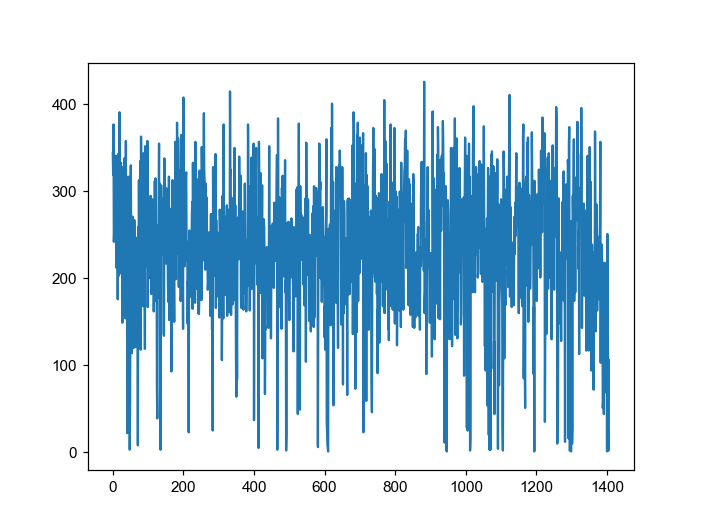

In [88]:
# number of probes histogram
fig, ax = plt.subplots()
ax.plot(cand_prob_nums)
plt.show()

In [89]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 300 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 50
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:0, screen genome to keep 300 probes
-- filtering region:1, screen genome to keep 300 probes
-- filtering region:2, screen genome to keep 300 probes
-- filtering region:3, directly append 242 probes
-- filtering region:4, directly append 256 probes
-- filtering region:5, screen genome to keep 300 probes
-- filtering region:6, directly append 300 probes
-- filtering region:7, screen genome to keep 300 probes
-- filtering region:8, screen genome to keep 300 probes
-- filtering region:9, directly append 264 probes
-- filtering region:10, directly append 216 probes
-- filtering region:11, directly append 212 probes
-- filtering region:12, directly append 240 probes
-- filtering region:13, screen genome to keep 300 probes
-- filtering region:14, directly append 176 probes
-- filtering region:15, screen genome to keep 300 probes
-- filtering region:16, directly append 245 probes
-- filtering region:17, directly append 203 probes
-- filteri

-- filtering region:212, screen genome to keep 300 probes
-- filtering region:213, directly append 200 probes
-- filtering region:214, directly append 219 probes
-- filtering region:215, directly append 142 probes
-- filtering region:216, screen genome to keep 300 probes
-- filtering region:217, directly append 278 probes
-- filtering region:218, directly append 252 probes
-- filtering region:219, directly append 258 probes
-- filtering region:220, directly append 214 probes
-- filtering region:221, directly append 256 probes
-- filtering region:222, directly append 292 probes
-- filtering region:223, screen genome to keep 300 probes
-- filtering region:224, screen genome to keep 300 probes
-- filtering region:225, directly append 234 probes
-- filtering region:226, directly append 220 probes
-- filtering region:227, directly append 242 probes
-- filtering region:228, directly append 148 probes
-- filtering region:229, directly append 197 probes
-- filtering region:230, directly append

-- filtering region:446, directly append 108 probes
-- filtering region:447, directly append 181 probes
-- filtering region:448, directly append 127 probes
-- filtering region:449, directly append 228 probes
-- filtering region:450, directly append 268 probes
-- filtering region:451, directly append 258 probes
-- filtering region:452, directly append 197 probes
-- filtering region:453, directly append 67 probes
-- filtering region:454, directly append 145 probes
-- filtering region:455, directly append 142 probes
-- filtering region:456, directly append 217 probes
-- filtering region:457, directly append 207 probes
-- filtering region:458, directly append 236 probes
-- filtering region:459, directly append 180 probes
-- filtering region:460, directly append 202 probes
-- filtering region:461, directly append 209 probes
-- filtering region:462, directly append 170 probes
-- filtering region:463, directly append 143 probes
-- filtering region:464, directly append 211 probes
-- filtering 

-- filtering region:669, screen genome to keep 300 probes
-- filtering region:670, screen genome to keep 300 probes
-- filtering region:671, directly append 199 probes
-- filtering region:672, directly append 171 probes
-- filtering region:673, directly append 120 probes
-- filtering region:674, directly append 258 probes
-- filtering region:675, screen genome to keep 300 probes
-- filtering region:676, screen genome to keep 300 probes
-- filtering region:677, screen genome to keep 300 probes
-- filtering region:678, screen genome to keep 300 probes
-- filtering region:679, screen genome to keep 300 probes
-- filtering region:680, directly append 294 probes
-- filtering region:681, screen genome to keep 300 probes
-- filtering region:682, directly append 147 probes
-- filtering region:683, directly append 285 probes
-- filtering region:684, directly append 253 probes
-- filtering region:685, screen genome to keep 300 probes
-- filtering region:686, directly append 266 probes
-- filteri

-- filtering region:905, screen genome to keep 300 probes
-- filtering region:906, directly append 194 probes
-- filtering region:907, directly append 143 probes
-- filtering region:908, directly append 216 probes
-- filtering region:909, directly append 181 probes
-- filtering region:910, directly append 155 probes
-- filtering region:911, directly append 187 probes
-- filtering region:912, directly append 230 probes
-- filtering region:913, directly append 169 probes
-- filtering region:914, directly append 176 probes
-- filtering region:915, directly append 166 probes
-- filtering region:916, directly append 250 probes
-- filtering region:917, directly append 250 probes
-- filtering region:918, directly append 259 probes
-- filtering region:919, directly append 157 probes
-- filtering region:920, directly append 187 probes
-- filtering region:921, directly append 173 probes
-- filtering region:922, directly append 174 probes
-- filtering region:923, directly append 141 probes
-- fil

-- filtering region:1261, screen genome to keep 300 probes
-- filtering region:1262, directly append 85 probes
-- filtering region:1263, directly append 189 probes
-- filtering region:1264, directly append 279 probes
-- filtering region:1265, directly append 99 probes
-- filtering region:1269, directly append 51 probes
-- filtering region:1270, screen genome to keep 300 probes
-- filtering region:1271, screen genome to keep 300 probes
-- filtering region:1272, screen genome to keep 300 probes
-- filtering region:1273, directly append 297 probes
-- filtering region:1274, directly append 192 probes
-- filtering region:1275, screen genome to keep 300 probes
-- filtering region:1276, directly append 244 probes
-- filtering region:1277, screen genome to keep 300 probes
-- filtering region:1278, directly append 150 probes
-- filtering region:1279, directly append 193 probes
-- filtering region:1280, directly append 296 probes
-- filtering region:1281, directly append 275 probes
-- filtering 

-- filtering region:1445, screen genome to keep 300 probes
-- filtering region:1446, directly append 274 probes
-- filtering region:1447, screen genome to keep 300 probes
-- filtering region:1448, directly append 267 probes
-- filtering region:1449, screen genome to keep 300 probes
-- filtering region:1450, directly append 211 probes
-- filtering region:1451, directly append 255 probes
-- filtering region:1452, directly append 113 probes
-- filtering region:1453, screen genome to keep 300 probes
-- filtering region:1454, directly append 277 probes
-- filtering region:1455, directly append 290 probes
-- filtering region:1456, directly append 270 probes
-- filtering region:1457, directly append 281 probes
-- filtering region:1458, screen genome to keep 300 probes
-- filtering region:1459, screen genome to keep 300 probes
-- filtering region:1461, directly append 143 probes
-- filtering region:1462, directly append 238 probes
-- filtering region:1463, directly append 268 probes
-- filteri

In [90]:
len(filtered_pb_dict)

1352

<IPython.core.display.Javascript object>


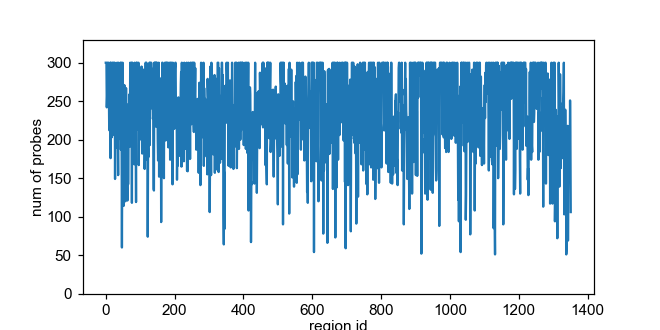

In [91]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

In [93]:
chr_2_region_savefile = os.path.join(library_folder, 'chr_2_final_region_num.pkl')
if not os.path.exists(chr_2_region_savefile) or overwrite:
    filtered_reg_names = {}
    for _reg, _pbde in filtered_pb_dict.items():
        if len(_pbde.kept_probes) > 0:
            filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']

    chr_2_region_num = {}
    for _reg, _info in filtered_reg_names.items():
        _chr = _info.split('_')[0].split(':')[0]
        if _chr not in chr_2_region_num:
            chr_2_region_num[_chr] = 1
        else:
            chr_2_region_num[_chr] += 1
    pickle.dump(chr_2_region_num, open(chr_2_region_savefile, 'wb'))
else:
    chr_2_region_num = pickle.dump(open(chr_2_region_savefile, 'rb'))

In [94]:
chr_2_region_num

{'1': 84,
 '2': 90,
 '3': 77,
 '4': 74,
 '5': 69,
 '6': 64,
 '7': 59,
 '8': 55,
 '9': 53,
 '10': 65,
 '11': 61,
 '12': 62,
 '13': 48,
 '14': 56,
 '15': 49,
 '16': 48,
 '17': 46,
 '18': 47,
 '19': 53,
 '20': 60,
 '21': 30,
 '22': 29,
 'X': 59,
 'Y': 14}

In [95]:
chr_2_region_names = {}
for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)


In [96]:
pickle.dump(chr_2_region_names, open(os.path.join(library_folder, 'chr_2_region_names.pkl'), 'wb'))

In [125]:
# clear memory
del(_pbde)
del(_pb_class)

<a id='3'></a>
# 3. Load and asssemble probes

<a id='3.1'></a>
## 3.1 design readout mapping dict (region_to_readout)

load directly from http://localhost:8889/notebooks/Chromatin_Analysis_Scripts/Library_design/CTP-10_Aire/CTP-10_Aire_introns_DNA-MERFISH.ipynb#3.3-assemble-probes

<a id='3.2'></a>
## 3.2 loading components

### primers
pick primer set 2,9

In [97]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


### readouts

In [98]:
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))

In [99]:
region_2_readout_dict

{100: ['c28', 'c43', 'c97'],
 101: ['c5', 'c12', 'c60'],
 102: ['c15', 'c53', 'c67'],
 103: ['c3', 'c57', 'c80'],
 104: ['c4', 'c27', 'c87'],
 105: ['c37', 'c47', 'c69'],
 106: ['c1', 'c68', 'c85'],
 107: ['c21', 'c33', 'c91'],
 108: ['c9', 'c70', 'c94'],
 109: ['c45', 'c56', 'c65'],
 110: ['c13', 'c76', 'c84'],
 111: ['c22', 'c25', 'c78'],
 112: ['c11', 'c26', 'c49'],
 114: ['c46', 'c62', 'c88'],
 115: ['c6', 'c24', 'c30'],
 116: ['c7', 'c29', 'c32'],
 117: ['c16', 'c90', 'c95'],
 118: ['c34', 'c44', 'c93'],
 119: ['c19', 'c83', 'c85'],
 120: ['c8', 'c18', 'c58'],
 121: ['c35', 'c39', 'c72'],
 122: ['c45', 'c57', 'c81'],
 123: ['c41', 'c71', 'c97'],
 124: ['c17', 'c43', 'c96'],
 125: ['c20', 'c28', 'c36'],
 126: ['c23', 'c31', 'c55'],
 127: ['c53', 'c73', 'c82'],
 128: ['c62', 'c64', 'c79'],
 129: ['c74', 'c84', 'c95'],
 130: ['c60', 'c61', 'c89'],
 131: ['c0', 'c24', 'c25'],
 132: ['c5', 'c10', 'c54'],
 133: ['c4', 'c40', 'c70'],
 134: ['c48', 'c66', 'c85'],
 137: ['c16', 'c63', 'c76

In [100]:
# collect types
readout_usage_by_type = {}
for _region, _infos in region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

In [101]:
readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}
readout_dict ={}

In [102]:
reload(library_tools.assemble)
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'
readout_start = 0
num_color = 2
comb_readouts = library_tools.assemble.load_readouts(readout_usage_dict['c'], 
                                                       _type='snr_after_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start,
                                                       )
readout_dict['c'] = comb_readouts

In [104]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


<a id='3.3'></a>
## 3.3 assemble probes

In [108]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=20, 
                                               num_readout_per_probe=4, 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['c']
--- assemblying 300 probes in region: 0
--- assemblying 300 probes in region: 1
--- assemblying 300 probes in region: 2
--- assemblying 242 probes in region: 3
--- assemblying 256 probes in region: 4
--- assemblying 300 probes in region: 5
--- assemblying 300 probes in region: 6
--- assemblying 300 probes in region: 7
--- assemblying 300 probes in region: 8
--- assemblying 264 probes in region: 9
--- assemblying 216 probes in region: 10
--- assemblying 212 probes in region: 11
--- assemblying 240 probes in region: 12
--- assemblying 300 probes in region: 13
--- assemblying 176 probes in region: 14
--- assemblying 300 probes in region: 15
--- assemblying 245 probes in region: 16
--- assemblying 203 probes in region: 17
--- assemblying 204 probes in region: 18
--- assemblying 300 probes in region: 19
--- assemblying 206 probes in region: 20
--- assemblying 255 probes in region: 21
--- asse

--- assemblying 258 probes in region: 219
--- assemblying 214 probes in region: 220
--- assemblying 256 probes in region: 221
--- assemblying 292 probes in region: 222
--- assemblying 300 probes in region: 223
--- assemblying 300 probes in region: 224
--- assemblying 234 probes in region: 225
--- assemblying 220 probes in region: 226
--- assemblying 242 probes in region: 227
--- assemblying 148 probes in region: 228
--- assemblying 197 probes in region: 229
--- assemblying 166 probes in region: 230
--- assemblying 196 probes in region: 233
--- assemblying 255 probes in region: 234
--- assemblying 233 probes in region: 235
--- assemblying 182 probes in region: 236
--- assemblying 179 probes in region: 237
--- assemblying 251 probes in region: 238
--- assemblying 231 probes in region: 239
--- assemblying 234 probes in region: 240
--- assemblying 272 probes in region: 241
--- assemblying 288 probes in region: 242
--- assemblying 165 probes in region: 243
--- assemblying 300 probes in regi

--- assemblying 300 probes in region: 426
--- assemblying 217 probes in region: 427
--- assemblying 243 probes in region: 428
--- assemblying 193 probes in region: 429
--- assemblying 236 probes in region: 430
--- assemblying 237 probes in region: 431
--- assemblying 270 probes in region: 432
--- assemblying 300 probes in region: 435
--- assemblying 294 probes in region: 436
--- assemblying 188 probes in region: 437
--- assemblying 206 probes in region: 438
--- assemblying 300 probes in region: 439
--- assemblying 300 probes in region: 440
--- assemblying 183 probes in region: 441
--- assemblying 276 probes in region: 442
--- assemblying 241 probes in region: 443
--- assemblying 300 probes in region: 444
--- assemblying 108 probes in region: 446
--- assemblying 181 probes in region: 447
--- assemblying 127 probes in region: 448
--- assemblying 228 probes in region: 449
--- assemblying 268 probes in region: 450
--- assemblying 258 probes in region: 451
--- assemblying 197 probes in regi

--- assemblying 262 probes in region: 649
--- assemblying 241 probes in region: 650
--- assemblying 146 probes in region: 651
--- assemblying 300 probes in region: 652
--- assemblying 300 probes in region: 653
--- assemblying 271 probes in region: 654
--- assemblying 300 probes in region: 655
--- assemblying 292 probes in region: 656
--- assemblying 186 probes in region: 657
--- assemblying 300 probes in region: 658
--- assemblying 54 probes in region: 659
--- assemblying 278 probes in region: 660
--- assemblying 184 probes in region: 662
--- assemblying 205 probes in region: 663
--- assemblying 255 probes in region: 664
--- assemblying 266 probes in region: 665
--- assemblying 273 probes in region: 666
--- assemblying 172 probes in region: 667
--- assemblying 300 probes in region: 668
--- assemblying 300 probes in region: 669
--- assemblying 300 probes in region: 670
--- assemblying 199 probes in region: 671
--- assemblying 171 probes in region: 672
--- assemblying 120 probes in regio

--- assemblying 300 probes in region: 857
--- assemblying 252 probes in region: 858
--- assemblying 240 probes in region: 859
--- assemblying 144 probes in region: 860
--- assemblying 300 probes in region: 861
--- assemblying 233 probes in region: 862
--- assemblying 282 probes in region: 863
--- assemblying 250 probes in region: 864
--- assemblying 223 probes in region: 865
--- assemblying 216 probes in region: 866
--- assemblying 164 probes in region: 867
--- assemblying 289 probes in region: 868
--- assemblying 300 probes in region: 869
--- assemblying 300 probes in region: 870
--- assemblying 300 probes in region: 871
--- assemblying 300 probes in region: 872
--- assemblying 265 probes in region: 873
--- assemblying 300 probes in region: 874
--- assemblying 212 probes in region: 875
--- assemblying 262 probes in region: 876
--- assemblying 268 probes in region: 877
--- assemblying 300 probes in region: 878
--- assemblying 215 probes in region: 888
--- assemblying 279 probes in regi

--- assemblying 184 probes in region: 1109
--- assemblying 300 probes in region: 1110
--- assemblying 300 probes in region: 1111
--- assemblying 300 probes in region: 1112
--- assemblying 266 probes in region: 1113
--- assemblying 217 probes in region: 1114
--- assemblying 253 probes in region: 1115
--- assemblying 184 probes in region: 1116
--- assemblying 288 probes in region: 1117
--- assemblying 231 probes in region: 1118
--- assemblying 300 probes in region: 1119
--- assemblying 228 probes in region: 1120
--- assemblying 298 probes in region: 1121
--- assemblying 227 probes in region: 1122
--- assemblying 267 probes in region: 1123
--- assemblying 201 probes in region: 1124
--- assemblying 208 probes in region: 1125
--- assemblying 300 probes in region: 1126
--- assemblying 241 probes in region: 1127
--- assemblying 235 probes in region: 1128
--- assemblying 300 probes in region: 1129
--- assemblying 300 probes in region: 1130
--- assemblying 272 probes in region: 1131
--- assembl

--- assemblying 300 probes in region: 1323
--- assemblying 300 probes in region: 1324
--- assemblying 300 probes in region: 1325
--- assemblying 129 probes in region: 1330
--- assemblying 242 probes in region: 1331
--- assemblying 278 probes in region: 1332
--- assemblying 136 probes in region: 1333
--- assemblying 161 probes in region: 1334
--- assemblying 300 probes in region: 1335
--- assemblying 266 probes in region: 1336
--- assemblying 300 probes in region: 1337
--- assemblying 188 probes in region: 1338
--- assemblying 238 probes in region: 1339
--- assemblying 300 probes in region: 1340
--- assemblying 300 probes in region: 1341
--- assemblying 261 probes in region: 1342
--- assemblying 201 probes in region: 1343
--- assemblying 274 probes in region: 1344
--- assemblying 300 probes in region: 1345
--- assemblying 298 probes in region: 1346
--- assemblying 179 probes in region: 1347
--- assemblying 130 probes in region: 1348
--- assemblying 300 probes in region: 1349
--- assembl

# 4.Check quality


## 4.1 Load probes

Checking procedures could restart from here

In [106]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 317858


### Manually input the following info to double check!

In [13]:
num_readout_per_probe = 4
primer_len=20
target_len=42
min_num_probes = 40
# merfish related
num_on_bits = 3

### 4.1.1 check primer usage

In [110]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 317858
True


### 4.1.2 check region probe number

In [111]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: 0 -> 300
gene: 1 -> 300
gene: 2 -> 300
gene: 3 -> 242
gene: 4 -> 256
gene: 5 -> 300
gene: 6 -> 300
gene: 7 -> 300
gene: 8 -> 300
gene: 9 -> 264
gene: 10 -> 216
gene: 11 -> 212
gene: 12 -> 240
gene: 13 -> 300
gene: 14 -> 176
gene: 15 -> 300
gene: 16 -> 245
gene: 17 -> 203
gene: 18 -> 204
gene: 19 -> 300
gene: 20 -> 206
gene: 21 -> 255
gene: 22 -> 300
gene: 23 -> 300
gene: 24 -> 279
gene: 25 -> 238
gene: 26 -> 300
gene: 27 -> 149
gene: 28 -> 262
gene: 29 -> 199
gene: 30 -> 263
gene: 31 -> 215
gene: 32 -> 190
gene: 33 -> 300
gene: 34 -> 230
gene: 35 -> 203
gene: 36 -> 154
gene: 37 -> 300
gene: 38 -> 211
gene: 39 -> 237
gene: 40 -> 293
gene: 42 -> 201
gene: 43 -> 235
gene: 44 -> 300
gene: 45 -> 187
gene: 46 -> 300
gene: 47 -> 213
gene: 57 -> 60
gene: 60 -> 187
gene: 62 -> 300
gene: 63 -> 241
gene: 64 -> 199
gene: 65 -> 114
gene: 66 -> 127
gene: 67 -> 271
gene: 68 -> 226
gene: 69 -> 128
gene: 70 -> 120
gene: 71 -> 137
gene: 72 -> 267
gene: 73 -> 198
gene: 74 -> 173
gene: 75 -> 149
gen

<IPython.core.display.Javascript object>


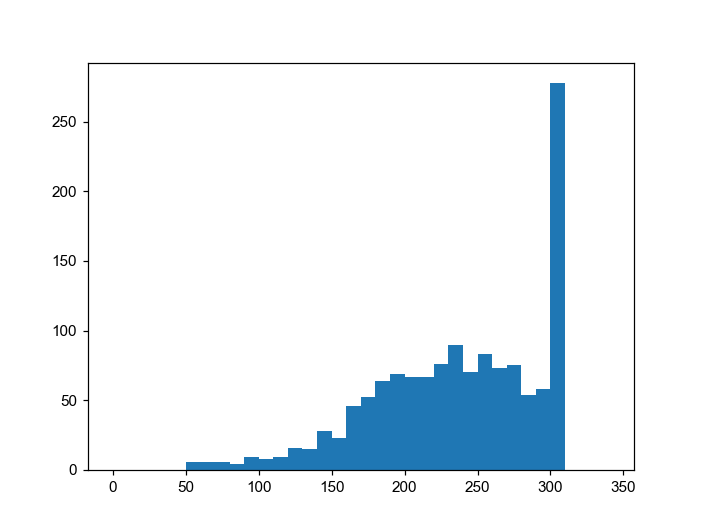

In [112]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,350,10))
plt.show()

### 4.1.3 check readout usage for each gene

In [116]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_on_bits)
print(reg2readout_check)

0 -> ['NDB_683', 'NDB_758', 'NDB_887']
1 -> ['NDB_718', 'NDB_631', 'NDB_1066']
2 -> ['NDB_847', 'NDB_832', 'NDB_779']
3 -> ['NDB_755', 'NDB_899', 'NDB_889']
4 -> ['NDB_710', 'NDB_665', 'NDB_1028']
5 -> ['NDB_643', 'NDB_805', 'NDB_730']
6 -> ['NDB_883', 'NDB_1060', 'NDB_853']
7 -> ['NDB_974', 'NDB_754', 'NDB_634']
8 -> ['NDB_661', 'NDB_901', 'NDB_835']
9 -> ['NDB_878', 'NDB_836', 'NDB_742']
10 -> ['NDB_844', 'NDB_812', 'NDB_637']
11 -> ['NDB_737', 'NDB_935', 'NDB_925']
12 -> ['NDB_790', 'NDB_788', 'NDB_934']
13 -> ['NDB_746', 'NDB_758', 'NDB_818']
14 -> ['NDB_961', 'NDB_631', 'NDB_866']
15 -> ['NDB_652', 'NDB_958', 'NDB_926']
16 -> ['NDB_815', 'NDB_887', 'NDB_989']
17 -> ['NDB_643', 'NDB_1028', 'NDB_910']
18 -> ['NDB_760', 'NDB_734', 'NDB_712']
19 -> ['NDB_965', 'NDB_661', 'NDB_899']
20 -> ['NDB_653', 'NDB_977', 'NDB_940']
21 -> ['NDB_743', 'NDB_917', 'NDB_715']
22 -> ['NDB_698', 'NDB_883', 'NDB_1075']
23 -> ['NDB_728', 'NDB_946', 'NDB_838']
24 -> ['NDB_754', 'NDB_860', 'NDB_752']
25 ->

### 4.1.4 check readout usage in the library

In [119]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_on_bits)
print(readout2reg_check)

-- extracting probes from >region:0, region:1, region:2, region:3, region:4, region:5, region:6, region:7, region:8, region:9, region:10, region:11, region:12, region:13, region:14, region:15, region:16, region:17, region:18, region:19, region:20, region:21, region:22, region:23, region:24, region:25, region:26, region:27, region:28, region:29, region:30, region:31, region:32, region:33, region:34, region:35, region:36, region:37, region:38, region:39, region:40, region:42, region:43, region:44, region:45, region:46, region:47, region:57, region:60, region:62, region:63, region:64, region:65, region:66, region:67, region:68, region:69, region:70, region:71, region:72, region:73, region:74, region:75, region:76, region:77, region:78, region:79, region:80, region:81, region:83, region:84, region:85, region:86, region:87, region:88, region:89, region:90, region:91, region:92, region:93, region:94, region:95, region:96, region:98, region:100, region:101, region:102, region:103, region:104,

, region:749, region:750, region:751, region:752, region:753, region:754, region:755, region:756, region:757, region:758, region:759, region:760, region:761, region:762, region:763, region:764, region:765, region:766, region:767, region:768, region:769, region:770, region:774, region:775, region:776, region:777, region:778, region:779, region:780, region:782, region:783, region:784, region:785, region:786, region:787, region:788, region:789, region:790, region:791, region:792, region:793, region:794, region:795, region:796, region:797, region:798, region:799, region:800, region:801, region:802, region:803, region:804, region:805, region:806, region:807, region:808, region:809, region:810, region:811, region:812, region:813, region:814, region:815, region:816, region:817, region:819, region:820, region:821, region:822, region:823, region:824, region:825, region:826, region:827, region:828, region:829, region:832, region:833, region:834, region:835, region:836, region:837, region:838, re

, region:1541, region:1542, region:1548, {'NDB_683': ['0', '0', '0', '39', '39', '39', '89', '89', '89', '110', '110', '110', '140', '140', '140', '194', '194', '194', '237', '237', '237', '267', '267', '267', '274', '274', '274', '324', '324', '324', '350', '350', '350', '372', '372', '372', '426', '426', '426', '454', '454', '454', '521', '521', '521', '590', '590', '590', '626', '626', '626', '676', '676', '676', '685', '685', '685', '718', '718', '718', '775', '775', '775', '812', '812', '812', '854', '854', '854', '870', '870', '870', '902', '902', '902', '927', '927', '927', '955', '955', '955', '1004', '1004', '1004', '1037', '1037', '1037', '1081', '1081', '1081', '1107', '1107', '1107', '1160', '1160', '1160', '1173', '1173', '1173', '1211', '1211', '1211', '1265', '1265', '1265', '1308', '1308', '1308', '1355', '1355', '1355', '1391', '1391', '1391', '1442', '1442', '1442', '1476', '1476', '1476', '1518', '1518', '1518'], 'NDB_758': ['0', '0', '0', '13', '13', '13', '87', '87

### 4.1.5 check bewteen probes

In [120]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder, save=False) 

In [121]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [122]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_1:1235001-1265000_gene_0_pb_141_pos_13330_strand_+_readouts_[NDB_683_c,NDB_683_c,NDB_683_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:81, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_145_pos_13649_strand_+_readouts_[NDB_758_c,NDB_758_c,NDB_758_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_146_pos_13789_strand_+_readouts_[NDB_887_c,NDB_887_c,NDB_887_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:80, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_147_pos_13855_strand_+_readouts_[NDB_683_c,NDB_683_c,NDB_683_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:84, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_149_pos_14659_strand_-_readouts_[NDB_887_c,NDB_887_c,NDB_887_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:62, dumped
--- Sequence:loc_1:3735001-3765000_gene_1_pb_56_pos_4401_strand_-_readouts_[NDB_1066_c,NDB_1066_c,NDB_1066_c]_primers_[W1A03_primer_2,W1A10_primer_9] got h

--- Sequence:loc_4:83735001-83765000_gene_307_pb_125_pos_20855_strand_-_readouts_[NDB_926_c,NDB_926_c,NDB_926_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:150, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_36_pos_4620_strand_+_readouts_[NDB_643_c,NDB_643_c,NDB_643_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:71, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_37_pos_4701_strand_-_readouts_[NDB_1027_c,NDB_1027_c,NDB_1027_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:91, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_38_pos_5467_strand_-_readouts_[NDB_878_c,NDB_878_c,NDB_878_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:84, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_39_pos_5728_strand_+_readouts_[NDB_643_c,NDB_643_c,NDB_643_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_40_pos_6638_strand_-_readouts_[NDB_1027_c,NDB_1027_c,NDB_1027_c]_primers_[W1A03_

--- Sequence:loc_7:68735001-68765000_gene_517_pb_24_pos_2347_strand_-_readouts_[NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:53, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_25_pos_2407_strand_-_readouts_[NDB_878_c,NDB_878_c,NDB_878_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_26_pos_2479_strand_-_readouts_[NDB_866_c,NDB_866_c,NDB_866_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:79, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_29_pos_2681_strand_+_readouts_[NDB_866_c,NDB_866_c,NDB_866_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_30_pos_2755_strand_+_readouts_[NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_31_pos_2825_strand_+_readouts_[NDB_878_c,NDB_878_c,NDB_878_c]_primers_[W1A03_primer_2,W1A10_prim

--- Sequence:loc_11:62985001-63015000_gene_777_pb_48_pos_4612_strand_-_readouts_[NDB_716_c,NDB_716_c,NDB_716_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:89, dumped
--- Sequence:loc_11:74985001-75015000_gene_783_pb_197_pos_23135_strand_+_readouts_[NDB_1028_c,NDB_1028_c,NDB_1028_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:125, dumped
--- Sequence:loc_12:4985001-5015000_gene_815_pb_258_pos_25626_strand_+_readouts_[NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:91, dumped
--- Sequence:loc_12:4985001-5015000_gene_815_pb_260_pos_25784_strand_+_readouts_[NDB_641_c,NDB_641_c,NDB_641_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:95, dumped
--- Sequence:loc_12:4985001-5015000_gene_815_pb_261_pos_25887_strand_+_readouts_[NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:90, dumped
--- Sequence:loc_12:4985001-5015000_gene_815_pb_262_pos_25939_strand_+_readouts_[NDB_856_c,NDB_856_c,NDB_856_c]_primers_[W1A03_primer_

--- Sequence:loc_14:50235001-50265000_gene_969_pb_21_pos_3641_strand_-_readouts_[NDB_875_c,NDB_875_c,NDB_875_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_14:57735001-57765000_gene_974_pb_121_pos_18282_strand_+_readouts_[NDB_889_c,NDB_889_c,NDB_889_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_14:59235001-59265000_gene_975_pb_60_pos_5799_strand_+_readouts_[NDB_817_c,NDB_817_c,NDB_817_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:86, dumped
--- Sequence:loc_14:77235001-77265000_gene_987_pb_7_pos_405_strand_+_readouts_[NDB_994_c,NDB_994_c,NDB_994_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:59, dumped
--- Sequence:loc_14:77235001-77265000_gene_987_pb_9_pos_565_strand_+_readouts_[NDB_880_c,NDB_880_c,NDB_880_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_14:77235001-77265000_gene_987_pb_10_pos_669_strand_-_readouts_[NDB_994_c,NDB_994_c,NDB_994_c]_primers_[W1A03_primer_2,W1A10_p

--- Sequence:loc_16:84735001-84765000_gene_1130_pb_290_pos_28753_strand_+_readouts_[NDB_910_c,NDB_910_c,NDB_910_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:57, dumped
--- Sequence:loc_16:84735001-84765000_gene_1130_pb_292_pos_28847_strand_-_readouts_[NDB_653_c,NDB_653_c,NDB_653_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_16:87735001-87765000_gene_1132_pb_38_pos_3587_strand_-_readouts_[NDB_901_c,NDB_901_c,NDB_901_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_16:87735001-87765000_gene_1132_pb_39_pos_4304_strand_-_readouts_[NDB_755_c,NDB_755_c,NDB_755_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:55, dumped
--- Sequence:loc_17:735001-765000_gene_1134_pb_37_pos_5569_strand_+_readouts_[NDB_706_c,NDB_706_c,NDB_706_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:57, dumped
--- Sequence:loc_17:735001-765000_gene_1134_pb_38_pos_5613_strand_+_readouts_[NDB_712_c,NDB_712_c,NDB_712_c]_primers_[W1A03_primer_2,W1

--- Sequence:loc_19:30485001-30515000_gene_1272_pb_150_pos_15605_strand_-_readouts_[NDB_958_c,NDB_958_c,NDB_958_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_19:31485001-31515000_gene_1273_pb_212_pos_21958_strand_+_readouts_[NDB_940_c,NDB_940_c,NDB_940_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_19:31485001-31515000_gene_1273_pb_214_pos_22419_strand_+_readouts_[NDB_818_c,NDB_818_c,NDB_818_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_19:33485001-33515000_gene_1275_pb_176_pos_20742_strand_-_readouts_[NDB_641_c,NDB_641_c,NDB_641_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_19:33485001-33515000_gene_1275_pb_177_pos_20787_strand_+_readouts_[NDB_868_c,NDB_868_c,NDB_868_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:73, dumped
--- Sequence:loc_19:33485001-33515000_gene_1275_pb_178_pos_20900_strand_+_readouts_[NDB_883_c,NDB_883_c,NDB_883_c]_primers_[W

--- Sequence:loc_22:29485001-29515000_gene_1439_pb_152_pos_24719_strand_-_readouts_[NDB_940_c,NDB_940_c,NDB_940_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:60, dumped
--- Sequence:loc_22:29485001-29515000_gene_1439_pb_153_pos_24869_strand_+_readouts_[NDB_790_c,NDB_790_c,NDB_790_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:61, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_73_pos_6569_strand_+_readouts_[NDB_716_c,NDB_716_c,NDB_716_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_74_pos_6800_strand_+_readouts_[NDB_832_c,NDB_832_c,NDB_832_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_75_pos_6856_strand_+_readouts_[NDB_961_c,NDB_961_c,NDB_961_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_76_pos_6937_strand_+_readouts_[NDB_716_c,NDB_716_c,NDB_716_c]_primers_[W1A03_pri

In [123]:
# clear memory
del(int_map)

### 4.1.6 finish checking, save

In [128]:
print(len(kept_records), len(cand_probes))

317417 317858


In [126]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [5]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

<module 'ImageAnalysis3.library_tools.quality_check' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\library_tools\\quality_check.py'>

In [9]:
if 'kept_records' not in locals() or len(kept_records) == 0:
    kept_records = []
    with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            kept_records.append(record)
print(len(kept_records))

317417


In [10]:
blast_database = os.path.join(reference_folder, 'blast_database', 'hg38')

check.Blast_probes(kept_records, library_folder, num_threads=44, 
                   blast_db=blast_database, blast_evalue=100, overwrite=False)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\blast_database\hg38
-- number of probes loaded: 317417
-- processing region: 0 with 295 probes
-- processing region: 1 with 287 probes
-- processing region: 10 with 216 probes
-- processing region: 100 with 300 probes
-- processing region: 1000 with 300 probes
-- processing region: 1001 with 300 probes
-- processing region: 1002 with 300 probes
-- processing region: 1003 with 287 probes
-- processing region: 1004 with 283 probes
-- processing region: 1005 with 292 probes
-- processing region: 101 with 282 probes
-- processing region: 102 with 240 probes
-- processing region: 1020 with 52 probes
-- processing region: 1023 with 217 probes
-- processing region: 1024 with 242 probes
-- processing region: 1025 with 300 probes
-- processing region: 1029 with 235 probes
-- processing region: 103 with 205 probes
-- processing region: 1030 with 209 probes
-- processing region: 1031 with 290 probes
-- pr

-- processing region: 1215 with 221 probes
-- processing region: 1216 with 216 probes
-- processing region: 1217 with 190 probes
-- processing region: 1218 with 235 probes
-- processing region: 1219 with 300 probes
-- processing region: 122 with 270 probes
-- processing region: 1220 with 300 probes
-- processing region: 1221 with 300 probes
-- processing region: 1222 with 179 probes
-- processing region: 1224 with 231 probes
-- processing region: 1225 with 282 probes
-- processing region: 1226 with 238 probes
-- processing region: 1227 with 215 probes
-- processing region: 1228 with 167 probes
-- processing region: 1229 with 235 probes
-- processing region: 123 with 182 probes
-- processing region: 1230 with 223 probes
-- processing region: 1231 with 241 probes
-- processing region: 1232 with 237 probes
-- processing region: 1233 with 223 probes
-- processing region: 1234 with 169 probes
-- processing region: 1235 with 241 probes
-- processing region: 1236 with 271 probes
-- processing

-- processing region: 1436 with 298 probes
-- processing region: 1437 with 300 probes
-- processing region: 1438 with 174 probes
-- processing region: 1439 with 196 probes
-- processing region: 144 with 187 probes
-- processing region: 1440 with 236 probes
-- processing region: 1441 with 184 probes
-- processing region: 1442 with 248 probes
-- processing region: 1443 with 300 probes
-- processing region: 1444 with 300 probes
-- processing region: 1445 with 296 probes
-- processing region: 1446 with 274 probes
-- processing region: 1447 with 300 probes
-- processing region: 1448 with 267 probes
-- processing region: 1449 with 298 probes
-- processing region: 145 with 178 probes
-- processing region: 1450 with 211 probes
-- processing region: 1451 with 255 probes
-- processing region: 1452 with 113 probes
-- processing region: 1453 with 300 probes
-- processing region: 1454 with 277 probes
-- processing region: 1455 with 290 probes
-- processing region: 1456 with 270 probes
-- processing

--- total time for blast 221: 12.402216911315918
-- processing region: 222 with 292 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_222.fasta
--- *blasting region: 222
--- total time for blast 222: 17.160659551620483
-- processing region: 223 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_223.fasta
--- *blasting region: 223
--- total time for blast 223: 12.219984292984009
-- processing region: 224 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_224.fasta
--- *blasting region: 224
--- total time for blast 224: 11.832507133483887
-- processing region: 225 with 233 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_225.fasta
--- *b

--- total time for blast 253: 13.196040391921997
-- processing region: 254 with 282 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_254.fasta
--- *blasting region: 254
--- total time for blast 254: 11.911815881729126
-- processing region: 255 with 225 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_255.fasta
--- *blasting region: 255
--- total time for blast 255: 11.930468797683716
-- processing region: 256 with 218 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_256.fasta
--- *blasting region: 256
--- total time for blast 256: 9.774390935897827
-- processing region: 257 with 288 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_257.fasta
--- *bl

--- total time for blast 283: 15.906776428222656
-- processing region: 284 with 215 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_284.fasta
--- *blasting region: 284
--- total time for blast 284: 11.548819541931152
-- processing region: 285 with 234 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_285.fasta
--- *blasting region: 285
--- total time for blast 285: 12.743504047393799
-- processing region: 286 with 187 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_286.fasta
--- *blasting region: 286
--- total time for blast 286: 12.945245742797852
-- processing region: 287 with 194 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_287.fasta
--- *b

--- total time for blast 314: 11.746732950210571
-- processing region: 315 with 228 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_315.fasta
--- *blasting region: 315
--- total time for blast 315: 10.720430850982666
-- processing region: 316 with 183 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_316.fasta
--- *blasting region: 316
--- total time for blast 316: 9.849338054656982
-- processing region: 317 with 251 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_317.fasta
--- *blasting region: 317
--- total time for blast 317: 11.530102252960205
-- processing region: 318 with 178 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_318.fasta
--- *bl

--- total time for blast 344: 11.510384798049927
-- processing region: 345 with 225 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_345.fasta
--- *blasting region: 345
--- total time for blast 345: 10.707138776779175
-- processing region: 346 with 273 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_346.fasta
--- *blasting region: 346
--- total time for blast 346: 10.291482210159302
-- processing region: 347 with 202 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_347.fasta
--- *blasting region: 347
--- total time for blast 347: 10.538837671279907
-- processing region: 348 with 223 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_348.fasta
--- *b

--- total time for blast 375: 10.71120810508728
-- processing region: 376 with 222 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_376.fasta
--- *blasting region: 376
--- total time for blast 376: 10.64453411102295
-- processing region: 377 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_377.fasta
--- *blasting region: 377
--- total time for blast 377: 12.023329257965088
-- processing region: 379 with 287 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_379.fasta
--- *blasting region: 379
--- total time for blast 379: 21.092720985412598
-- processing region: 38 with 211 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_38.fasta
--- *blast

--- total time for blast 405: 10.012699604034424
-- processing region: 406 with 261 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_406.fasta
--- *blasting region: 406
--- total time for blast 406: 12.061725616455078
-- processing region: 407 with 299 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_407.fasta
--- *blasting region: 407
--- total time for blast 407: 15.941278219223022
-- processing region: 408 with 162 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_408.fasta
--- *blasting region: 408
--- total time for blast 408: 11.155323266983032
-- processing region: 409 with 221 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_409.fasta
--- *b

--- total time for blast 439: 13.222516775131226
-- processing region: 44 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_44.fasta
--- *blasting region: 44
--- total time for blast 44: 15.341411113739014
-- processing region: 440 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_440.fasta
--- *blasting region: 440
--- total time for blast 440: 14.095738410949707
-- processing region: 441 with 183 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_441.fasta
--- *blasting region: 441
--- total time for blast 441: 7.746721982955933
-- processing region: 442 with 276 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_442.fasta
--- *blasti

--- total time for blast 47: 12.653436183929443
-- processing region: 470 with 131 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_470.fasta
--- *blasting region: 470
--- total time for blast 470: 7.9474122524261475
-- processing region: 471 with 199 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_471.fasta
--- *blasting region: 471
--- total time for blast 471: 11.260337352752686
-- processing region: 472 with 203 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_472.fasta
--- *blasting region: 472
--- total time for blast 472: 18.646443605422974
-- processing region: 473 with 203 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_473.fasta
--- *bl

--- total time for blast 502: 13.75308609008789
-- processing region: 503 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_503.fasta
--- *blasting region: 503
--- total time for blast 503: 14.589881181716919
-- processing region: 504 with 220 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_504.fasta
--- *blasting region: 504
--- total time for blast 504: 15.697477340698242
-- processing region: 505 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_505.fasta
--- *blasting region: 505
--- total time for blast 505: 13.156829595565796
-- processing region: 506 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_506.fasta
--- *bl

--- total time for blast 538: 11.440531015396118
-- processing region: 539 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_539.fasta
--- *blasting region: 539
--- total time for blast 539: 10.701436042785645
-- processing region: 540 with 179 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_540.fasta
--- *blasting region: 540
--- total time for blast 540: 11.630674362182617
-- processing region: 541 with 248 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_541.fasta
--- *blasting region: 541
--- total time for blast 541: 11.41148829460144
-- processing region: 542 with 227 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_542.fasta
--- *bl

--- total time for blast 572: 15.364760160446167
-- processing region: 573 with 206 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_573.fasta
--- *blasting region: 573
--- total time for blast 573: 13.91887640953064
-- processing region: 574 with 258 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_574.fasta
--- *blasting region: 574
--- total time for blast 574: 14.44568920135498
-- processing region: 575 with 204 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_575.fasta
--- *blasting region: 575
--- total time for blast 575: 10.291867733001709
-- processing region: 576 with 291 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_576.fasta
--- *bla

--- total time for blast 603: 12.269195079803467
-- processing region: 605 with 187 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_605.fasta
--- *blasting region: 605
--- total time for blast 605: 10.249423027038574
-- processing region: 606 with 293 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_606.fasta
--- *blasting region: 606
--- total time for blast 606: 16.251372814178467
-- processing region: 607 with 281 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_607.fasta
--- *blasting region: 607
--- total time for blast 607: 15.5404212474823
-- processing region: 608 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_608.fasta
--- *bla

--- total time for blast 65: 11.213362455368042
-- processing region: 650 with 241 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_650.fasta
--- *blasting region: 650
--- total time for blast 650: 12.30185604095459
-- processing region: 651 with 146 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_651.fasta
--- *blasting region: 651
--- total time for blast 651: 9.416022539138794
-- processing region: 652 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_652.fasta
--- *blasting region: 652
--- total time for blast 652: 14.274945735931396
-- processing region: 653 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_653.fasta
--- *blas

--- total time for blast 680: 13.789268493652344
-- processing region: 681 with 298 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_681.fasta
--- *blasting region: 681
--- total time for blast 681: 13.361067295074463
-- processing region: 682 with 147 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_682.fasta
--- *blasting region: 682
--- total time for blast 682: 8.378686428070068
-- processing region: 683 with 285 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_683.fasta
--- *blasting region: 683
--- total time for blast 683: 12.08499526977539
-- processing region: 684 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_684.fasta
--- *bla

--- total time for blast 710: 17.071231603622437
-- processing region: 711 with 290 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_711.fasta
--- *blasting region: 711
--- total time for blast 711: 12.810210227966309
-- processing region: 712 with 201 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_712.fasta
--- *blasting region: 712
--- total time for blast 712: 10.929173946380615
-- processing region: 713 with 236 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_713.fasta
--- *blasting region: 713
--- total time for blast 713: 11.233841896057129
-- processing region: 714 with 196 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_714.fasta
--- *b

--- total time for blast 740: 14.664421796798706
-- processing region: 741 with 266 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_741.fasta
--- *blasting region: 741
--- total time for blast 741: 10.722052097320557
-- processing region: 742 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_742.fasta
--- *blasting region: 742
--- total time for blast 742: 11.295562982559204
-- processing region: 743 with 297 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_743.fasta
--- *blasting region: 743
--- total time for blast 743: 13.253595113754272
-- processing region: 744 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_744.fasta
--- *b

--- total time for blast 775: 19.122682332992554
-- processing region: 776 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_776.fasta
--- *blasting region: 776
--- total time for blast 776: 10.828905820846558
-- processing region: 777 with 299 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_777.fasta
--- *blasting region: 777
--- total time for blast 777: 12.669139862060547
-- processing region: 778 with 252 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_778.fasta
--- *blasting region: 778
--- total time for blast 778: 12.660850286483765
-- processing region: 779 with 208 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_779.fasta
--- *b

--- total time for blast 805: 10.070269107818604
-- processing region: 806 with 291 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_806.fasta
--- *blasting region: 806
--- total time for blast 806: 12.350224018096924
-- processing region: 807 with 233 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_807.fasta
--- *blasting region: 807
--- total time for blast 807: 9.862711191177368
-- processing region: 808 with 197 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_808.fasta
--- *blasting region: 808
--- total time for blast 808: 12.026119232177734
-- processing region: 809 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_809.fasta
--- *bl

--- total time for blast 839: 38.57307434082031
-- processing region: 84 with 191 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_84.fasta
--- *blasting region: 84
--- total time for blast 84: 10.678701162338257
-- processing region: 840 with 264 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_840.fasta
--- *blasting region: 840
--- total time for blast 840: 14.639617681503296
-- processing region: 841 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_841.fasta
--- *blasting region: 841
--- total time for blast 841: 11.882013082504272
-- processing region: 843 with 148 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_843.fasta
--- *blasti

--- total time for blast 87: 13.098751068115234
-- processing region: 870 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_870.fasta
--- *blasting region: 870
--- total time for blast 870: 13.680725336074829
-- processing region: 871 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_871.fasta
--- *blasting region: 871
--- total time for blast 871: 12.06839632987976
-- processing region: 872 with 299 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_872.fasta
--- *blasting region: 872
--- total time for blast 872: 14.057522296905518
-- processing region: 873 with 261 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_873.fasta
--- *bla

--- total time for blast 907: 7.740641117095947
-- processing region: 908 with 216 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_908.fasta
--- *blasting region: 908
--- total time for blast 908: 14.478037118911743
-- processing region: 909 with 181 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_909.fasta
--- *blasting region: 909
--- total time for blast 909: 11.29277515411377
-- processing region: 91 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_91.fasta
--- *blasting region: 91
--- total time for blast 91: 11.439051151275635
-- processing region: 910 with 155 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_910.fasta
--- *blastin

--- total time for blast 949: 9.246926546096802
-- processing region: 95 with 214 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_95.fasta
--- *blasting region: 95
--- total time for blast 95: 11.763420820236206
-- processing region: 950 with 178 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_950.fasta
--- *blasting region: 950
--- total time for blast 950: 10.96482229232788
-- processing region: 951 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_951.fasta
--- *blasting region: 951
--- total time for blast 951: 9.5006582736969
-- processing region: 952 with 190 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_952.fasta
--- *blasting r

--- total time for blast 98: 9.363692045211792
-- processing region: 980 with 173 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_980.fasta
--- *blasting region: 980
--- total time for blast 980: 12.124159336090088
-- processing region: 981 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_981.fasta
--- *blasting region: 981
--- total time for blast 981: 12.631026029586792
-- processing region: 982 with 171 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_982.fasta
--- *blasting region: 982
--- total time for blast 982: 9.988569736480713
-- processing region: 983 with 236 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_983.fasta
--- *blas

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [14]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 120
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 317417
- Number of regions in this library: 1352
-- checking probes in region: 0
--- gene=0, id=137 removed by soft count = 135
--- gene=0, id=144 removed by hard count = 12
--- gene=0, id=158 removed by soft count = 61
--- gene=0, id=159 removed by soft count = 87
--- gene=0, id=160 removed by soft count = 230
--- number of probes: 295 , kept by blast: 290 , if remove dups: 290
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1
--- gene=1, id=67 removed by soft count = 197
--- gene=1, id=68 removed by soft count = 113
--- gene=1, id=132 removed by soft count = 106
--- gene=1, id=140 removed by soft count = 104
--- gene=1, id=143 removed by soft count = 134
--- gene=1, id=144 removed by soft count = 168
--- gene=1, id=145 removed by soft count = 144
--- gene=1, id=146 removed by soft count = 132
--- gene=1, id=147 removed by soft count = 307
--- number of probes: 287 , kept 

--- number of probes: 300 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 20
--- gene=20, id=97 removed by soft count = 1203
--- gene=20, id=112 removed by soft count = 139
--- gene=20, id=128 removed by soft count = 212
--- number of probes: 206 , kept by blast: 203 , if remove dups: 203
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 21
--- gene=21, id=108 removed by soft count = 61
--- gene=21, id=220 removed by soft count = 390
--- number of probes: 255 , kept by blast: 253 , if remove dups: 253
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 22
--- gene=22, id=72 removed by soft count = 145
--- gene=22, id=162 removed by soft count = 79
--- gene=22, id=163 removed by soft count = 51

--- gene=38, id=151 removed by soft count = 972
--- gene=38, id=174 removed by soft count = 95
--- number of probes: 211 , kept by blast: 209 , if remove dups: 209
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 39
--- gene=39, id=165 removed by soft count = 72
--- gene=39, id=178 removed by soft count = 76
--- number of probes: 237 , kept by blast: 235 , if remove dups: 235
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 40
--- gene=40, id=131 removed by soft count = 60
--- gene=40, id=288 removed by soft count = 529
--- number of probes: 293 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 42
--- gene=42, id=38 removed by soft count = 58
--- gene=42, id=85 removed by soft count = 87
---

--- gene=68, id=45 removed by soft count = 82
--- gene=68, id=46 removed by soft count = 102
--- gene=68, id=83 removed by soft count = 87
--- number of probes: 226 , kept by blast: 218 , if remove dups: 218
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 69
--- gene=69, id=6 removed by soft count = 128
--- gene=69, id=7 removed by soft count = 94
--- gene=69, id=9 removed by soft count = 126
--- gene=69, id=119 removed by soft count = 356
--- gene=69, id=120 removed by soft count = 413
--- gene=69, id=121 removed by soft count = 149
--- gene=69, id=123 removed by soft count = 461
--- gene=69, id=124 removed by soft count = 789
--- gene=69, id=125 removed by soft count = 222
--- gene=69, id=127 removed by soft count = 230
--- number of probes: 128 , kept by blast: 118 , if remove dups: 118
--- remove duplicated probes
-- number of probes kept for this region: 118
-- checking probes in region: 70
--- 

--- gene=80, id=34 removed by soft count = 174
--- gene=80, id=72 removed by soft count = 60
--- gene=80, id=151 removed by soft count = 122
--- gene=80, id=152 removed by soft count = 215
--- gene=80, id=153 removed by soft count = 195
--- gene=80, id=154 removed by soft count = 125
--- gene=80, id=155 removed by soft count = 133
--- gene=80, id=156 removed by soft count = 148
--- gene=80, id=157 removed by soft count = 191
--- gene=80, id=158 removed by soft count = 162
--- number of probes: 241 , kept by blast: 231 , if remove dups: 231
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 81
--- gene=81, id=181 removed by soft count = 215
--- gene=81, id=182 removed by soft count = 1061
--- gene=81, id=189 removed by soft count = 814
--- gene=81, id=199 removed by soft count = 1580
--- number of probes: 223 , kept by blast: 219 , if remove dups: 219
--- remove duplicated probes
--- keep probes in the c

--- gene=98, id=27 removed by soft count = 69
--- gene=98, id=107 removed by soft count = 120
--- gene=98, id=114 removed by soft count = 146
--- gene=98, id=115 removed by soft count = 155
--- gene=98, id=116 removed by soft count = 115
--- gene=98, id=118 removed by soft count = 99
--- gene=98, id=121 removed by soft count = 107
--- gene=98, id=135 removed by soft count = 126
--- number of probes: 166 , kept by blast: 158 , if remove dups: 158
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 100
--- gene=100, id=47 removed by soft count = 103
--- gene=100, id=48 removed by soft count = 92
--- gene=100, id=49 removed by soft count = 63
--- gene=100, id=51 removed by soft count = 86
--- gene=100, id=52 removed by soft count = 197
--- gene=100, id=53 removed by soft count = 466
--- gene=100, id=54 removed by soft count = 273
--- gene=100, id=271 removed by soft count = 2348
--- number of probes: 300 , 

--- number of probes: 228 , kept by blast: 225 , if remove dups: 225
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 117
--- gene=117, id=100 removed by soft count = 129
--- gene=117, id=106 removed by soft count = 674
--- gene=117, id=209 removed by soft count = 73
--- gene=117, id=268 removed by soft count = 142
--- number of probes: 276 , kept by blast: 272 , if remove dups: 272
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 118
--- number of probes: 216 , kept by blast: 216 , if remove dups: 216
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 119
--- gene=119, id=90 removed by soft count = 142
--- gene=119, id=142 removed by soft count = 133
--- gene=119, id=148 removed by soft count = 75
--- gene=119, id=150 removed by soft

--- gene=132, id=112 removed by soft count = 318
--- gene=132, id=113 removed by soft count = 265
--- gene=132, id=114 removed by soft count = 238
--- gene=132, id=115 removed by soft count = 63
--- gene=132, id=169 removed by soft count = 62
--- gene=132, id=174 removed by soft count = 64
--- gene=132, id=183 removed by soft count = 67
--- number of probes: 192 , kept by blast: 175 , if remove dups: 175
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 133
--- gene=133, id=111 removed by soft count = 133
--- gene=133, id=239 removed by soft count = 166
--- gene=133, id=266 removed by soft count = 91
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 134
--- gene=134, id=82 removed by soft count = 1065
--- gene=134, id=86 removed by soft count = 138
--

--- gene=154, id=180 removed by soft count = 101
--- number of probes: 283 , kept by blast: 278 , if remove dups: 278
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 155
--- gene=155, id=133 removed by soft count = 60
--- gene=155, id=134 removed by soft count = 61
--- gene=155, id=136 removed by soft count = 74
--- number of probes: 252 , kept by blast: 249 , if remove dups: 249
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 156
--- gene=156, id=125 removed by soft count = 368
--- gene=156, id=231 removed by soft count = 5316
--- number of probes: 292 , kept by blast: 290 , if remove dups: 290
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 157
--- number of probes: 255 , kept by blast: 255 , if remove dups: 255
--- remove dupl

--- gene=176, id=17 removed by soft count = 110
--- gene=176, id=18 removed by soft count = 269
--- gene=176, id=20 removed by soft count = 153
--- gene=176, id=23 removed by soft count = 239
--- gene=176, id=24 removed by soft count = 110
--- gene=176, id=25 removed by soft count = 276
--- gene=176, id=26 removed by soft count = 369
--- gene=176, id=28 removed by soft count = 53
--- gene=176, id=29 removed by soft count = 100
--- gene=176, id=39 removed by soft count = 208
--- gene=176, id=41 removed by soft count = 241
--- gene=176, id=42 removed by soft count = 480
--- gene=176, id=44 removed by soft count = 103
--- gene=176, id=45 removed by soft count = 4189
--- gene=176, id=91 removed by soft count = 462
--- gene=176, id=100 removed by soft count = 130
--- number of probes: 152 , kept by blast: 136 , if remove dups: 136
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 177
--- gene=177, id=8 remo

--- gene=192, id=13 removed by soft count = 2188
--- gene=192, id=110 removed by soft count = 2555
--- gene=192, id=112 removed by soft count = 240
--- gene=192, id=197 removed by soft count = 64
--- number of probes: 270 , kept by blast: 258 , if remove dups: 247
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 193
--- gene=193, id=1 removed by soft count = 136
--- gene=193, id=2 removed by soft count = 87
--- gene=193, id=181 removed by soft count = 333
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 194
--- gene=194, id=52 removed by soft count = 51
--- gene=194, id=101 removed by soft count = 296
--- gene=194, id=181 removed by soft count = 68
--- gene=194, id=187 removed by soft count = 74
--- number of probes: 297 , kept by blast: 293 , if re

--- gene=208, id=122 removed by soft count = 494
--- gene=208, id=126 removed by soft count = 163
--- number of probes: 174 , kept by blast: 168 , if remove dups: 168
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 209
--- gene=209, id=0 removed by soft count = 230
--- gene=209, id=29 removed by soft count = 77
--- gene=209, id=30 removed by soft count = 65
--- gene=209, id=91 removed by soft count = 83
--- gene=209, id=92 removed by soft count = 59
--- gene=209, id=94 removed by soft count = 52
--- gene=209, id=95 removed by soft count = 84
--- gene=209, id=97 removed by soft count = 84
--- gene=209, id=101 removed by soft count = 253
--- gene=209, id=102 removed by soft count = 325
--- gene=209, id=103 removed by soft count = 158
--- gene=209, id=104 removed by soft count = 353
--- gene=209, id=105 removed by soft count = 410
--- gene=209, id=107 removed by soft count = 167
--- gene=209, id=109 rem

--- gene=228, id=42 removed by soft count = 123
--- gene=228, id=67 removed by soft count = 469
--- gene=228, id=97 removed by soft count = 224
--- gene=228, id=108 removed by soft count = 66
--- gene=228, id=109 removed by soft count = 376
--- gene=228, id=110 removed by soft count = 346
--- gene=228, id=111 removed by soft count = 64
--- gene=228, id=112 removed by soft count = 353
--- number of probes: 148 , kept by blast: 140 , if remove dups: 140
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 229
--- gene=229, id=40 removed by soft count = 93
--- gene=229, id=186 removed by soft count = 76
--- number of probes: 197 , kept by blast: 195 , if remove dups: 195
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 230
--- gene=230, id=0 removed by soft count = 789
--- gene=230, id=1 removed by soft count = 186
--- gene

--- gene=245, id=11 removed by soft count = 77
--- gene=245, id=13 removed by soft count = 753
--- gene=245, id=14 removed by soft count = 231
--- gene=245, id=33 removed by soft count = 137
--- gene=245, id=39 removed by soft count = 105
--- gene=245, id=41 removed by soft count = 73
--- gene=245, id=48 removed by soft count = 66
--- gene=245, id=49 removed by soft count = 61
--- gene=245, id=69 removed by soft count = 140
--- gene=245, id=70 removed by soft count = 232
--- gene=245, id=73 removed by soft count = 266
--- gene=245, id=74 removed by soft count = 80
--- gene=245, id=90 removed by soft count = 375
--- gene=245, id=101 removed by soft count = 221
--- gene=245, id=109 removed by soft count = 103
--- gene=245, id=114 removed by soft count = 214
--- gene=245, id=115 removed by soft count = 155
--- gene=245, id=120 removed by soft count = 165
--- gene=245, id=122 removed by soft count = 66
--- gene=245, id=124 removed by soft count = 99
--- gene=245, id=125 removed by soft cou

--- gene=261, id=74 removed by soft count = 851
--- gene=261, id=77 removed by soft count = 63
--- gene=261, id=78 removed by soft count = 325
--- gene=261, id=106 removed by soft count = 271
--- gene=261, id=107 removed by soft count = 477
--- gene=261, id=118 removed by soft count = 288
--- gene=261, id=119 removed by soft count = 359
--- gene=261, id=131 removed by soft count = 58
--- gene=261, id=142 removed by soft count = 115
--- number of probes: 159 , kept by blast: 150 , if remove dups: 150
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 262
--- gene=262, id=79 removed by soft count = 985
--- gene=262, id=80 removed by soft count = 94
--- gene=262, id=150 removed by soft count = 207
--- gene=262, id=151 removed by soft count = 80
--- gene=262, id=154 removed by soft count = 71
--- gene=262, id=156 removed by soft count = 138
--- number of probes: 179 , kept by blast: 173 , if remove dups: 17

--- gene=277, id=90 removed by soft count = 460
--- gene=277, id=91 removed by soft count = 51
--- gene=277, id=192 removed by soft count = 62
--- gene=277, id=203 removed by soft count = 125
--- gene=277, id=206 removed by soft count = 68
--- gene=277, id=208 removed by soft count = 125
--- gene=277, id=217 removed by soft count = 157
--- gene=277, id=219 removed by soft count = 539
--- gene=277, id=220 removed by soft count = 612
--- number of probes: 300 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 278
--- gene=278, id=18 removed by soft count = 57
--- gene=278, id=20 removed by soft count = 54
--- gene=278, id=22 removed by soft count = 82
--- gene=278, id=45 removed by soft count = 53
--- gene=278, id=128 removed by soft count = 154
--- gene=278, id=164 removed by soft count = 715
--- gene=278, id=165 removed by soft count = 132
--- gene=278, id=166 

--- gene=291, id=99 removed by soft count = 139
--- gene=291, id=100 removed by soft count = 88
--- gene=291, id=113 removed by soft count = 81
--- number of probes: 195 , kept by blast: 188 , if remove dups: 188
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 292
--- gene=292, id=222 removed by soft count = 124
--- number of probes: 226 , kept by blast: 225 , if remove dups: 225
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 293
--- gene=293, id=5 removed by soft count = 120
--- gene=293, id=9 removed by soft count = 383
--- gene=293, id=13 removed by soft count = 57
--- gene=293, id=25 removed by soft count = 611
--- gene=293, id=107 removed by soft count = 278
--- gene=293, id=109 removed by soft count = 95
--- gene=293, id=142 removed by soft count = 297
--- gene=293, id=144 removed by soft count = 51
--- gene

--- gene=310, id=71 removed by soft count = 203
--- gene=310, id=97 removed by soft count = 154
--- gene=310, id=111 removed by soft count = 156
--- gene=310, id=112 removed by soft count = 76
--- number of probes: 166 , kept by blast: 152 , if remove dups: 146
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 311
--- gene=311, id=51 removed by soft count = 82
--- gene=311, id=70 removed by soft count = 157
--- gene=311, id=74 removed by soft count = 435
--- gene=311, id=75 removed by soft count = 112
--- gene=311, id=158 removed by soft count = 70
--- gene=311, id=229 removed by soft count = 230
--- number of probes: 267 , kept by blast: 261 , if remove dups: 261
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 312
--- gene=312, id=3 removed by soft count = 133
--- gene=312, id=5 removed by soft count = 1439
--- gene

--- gene=327, id=52 removed by soft count = 76
--- gene=327, id=53 removed by soft count = 86
--- gene=327, id=57 removed by soft count = 265
--- gene=327, id=63 removed by soft count = 228
--- gene=327, id=65 removed by soft count = 676
--- gene=327, id=67 removed by soft count = 235
--- gene=327, id=69 removed by soft count = 495
--- gene=327, id=70 removed by soft count = 1985
--- gene=327, id=71 removed by soft count = 128
--- gene=327, id=73 removed by soft count = 76
--- gene=327, id=74 removed by soft count = 61
--- gene=327, id=75 removed by soft count = 74
--- gene=327, id=78 removed by soft count = 56
--- number of probes: 106 , kept by blast: 91 , if remove dups: 91
--- remove duplicated probes
-- number of probes kept for this region: 91
-- checking probes in region: 328
--- gene=328, id=11 removed by soft count = 1216
--- gene=328, id=14 removed by soft count = 233
--- gene=328, id=15 removed by soft count = 781
--- gene=328, id=16 removed by soft count = 1380
--- gene=328

--- gene=338, id=128 removed by soft count = 209
--- gene=338, id=134 removed by soft count = 57
--- gene=338, id=139 removed by soft count = 53
--- gene=338, id=156 removed by soft count = 68
--- gene=338, id=175 removed by soft count = 114
--- number of probes: 222 , kept by blast: 206 , if remove dups: 206
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 339
--- gene=339, id=7 removed by soft count = 155
--- gene=339, id=63 removed by soft count = 2802
--- gene=339, id=96 removed by soft count = 207
--- gene=339, id=116 removed by soft count = 88
--- gene=339, id=117 removed by soft count = 71
--- number of probes: 257 , kept by blast: 252 , if remove dups: 252
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 340
--- gene=340, id=7 removed by soft count = 160
--- number of probes: 201 , kept by blast: 200 , if rem

--- gene=355, id=167 removed by soft count = 165
--- number of probes: 234 , kept by blast: 233 , if remove dups: 233
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 356
--- gene=356, id=47 removed by soft count = 82
--- gene=356, id=48 removed by soft count = 53
--- gene=356, id=67 removed by soft count = 931
--- gene=356, id=79 removed by soft count = 195
--- gene=356, id=80 removed by soft count = 152
--- gene=356, id=155 removed by soft count = 355
--- gene=356, id=156 removed by soft count = 295
--- gene=356, id=157 removed by soft count = 208
--- gene=356, id=158 removed by soft count = 286
--- number of probes: 257 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 357
--- gene=357, id=49 removed by soft count = 303
--- gene=357, id=56 removed by soft count = 95
--- ge

--- gene=368, id=25 removed by soft count = 65
--- gene=368, id=27 removed by soft count = 288
--- gene=368, id=29 removed by soft count = 493
--- gene=368, id=30 removed by soft count = 157
--- gene=368, id=33 removed by soft count = 68
--- gene=368, id=35 removed by soft count = 103
--- gene=368, id=40 removed by soft count = 896
--- gene=368, id=43 removed by soft count = 365
--- gene=368, id=44 removed by soft count = 948
--- gene=368, id=50 removed by soft count = 66
--- gene=368, id=56 removed by soft count = 187
--- gene=368, id=58 removed by soft count = 197
--- gene=368, id=59 removed by soft count = 396
--- gene=368, id=60 removed by soft count = 1065
--- gene=368, id=61 removed by soft count = 167
--- gene=368, id=62 removed by soft count = 12348
--- gene=368, id=63 removed by soft count = 469
--- number of probes: 64 , kept by blast: 30 , if remove dups: 30
-- number of probes kept for this region: 30
-- checking probes in region: 370
--- gene=370, id=152 removed by soft co

--- gene=388, id=20 removed by soft count = 103
--- number of probes: 277 , kept by blast: 276 , if remove dups: 276
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 389
--- gene=389, id=31 removed by soft count = 460
--- gene=389, id=35 removed by soft count = 123
--- gene=389, id=38 removed by soft count = 227
--- gene=389, id=40 removed by soft count = 219
--- gene=389, id=41 removed by soft count = 100
--- number of probes: 170 , kept by blast: 165 , if remove dups: 165
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 390
--- gene=390, id=1 removed by soft count = 52
--- gene=390, id=2 removed by soft count = 174
--- gene=390, id=4 removed by soft count = 3050
--- gene=390, id=5 removed by soft count = 175
--- gene=390, id=6 removed by soft count = 469
--- gene=390, id=8 removed by soft count = 95
--- gene=390, i

--- gene=402, id=1 removed by soft count = 320
--- gene=402, id=11 removed by soft count = 1086
--- gene=402, id=78 removed by soft count = 120
--- gene=402, id=83 removed by soft count = 100
--- gene=402, id=89 removed by soft count = 154
--- gene=402, id=164 removed by soft count = 135
--- gene=402, id=166 removed by soft count = 583
--- number of probes: 191 , kept by blast: 184 , if remove dups: 184
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 403
--- number of probes: 300 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 404
--- gene=404, id=189 removed by soft count = 151
--- gene=404, id=192 removed by soft count = 56
--- gene=404, id=193 removed by soft count = 100
--- gene=404, id=194 removed by soft count = 289
--- gene=404, id=195 removed by soft count = 74
---

--- gene=418, id=34 removed by soft count = 574
--- gene=418, id=120 removed by soft count = 85
--- gene=418, id=121 removed by soft count = 171
--- gene=418, id=123 removed by soft count = 65
--- gene=418, id=124 removed by soft count = 287
--- gene=418, id=151 removed by soft count = 550
--- gene=418, id=152 removed by soft count = 112
--- gene=418, id=154 removed by soft count = 357
--- gene=418, id=193 removed by soft count = 249
--- number of probes: 200 , kept by blast: 191 , if remove dups: 191
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 419
--- gene=419, id=64 removed by soft count = 88
--- gene=419, id=110 removed by soft count = 179
--- gene=419, id=240 removed by soft count = 84
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 421
--

--- gene=437, id=156 removed by soft count = 51
--- number of probes: 188 , kept by blast: 183 , if remove dups: 183
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 438
--- gene=438, id=36 removed by soft count = 109
--- gene=438, id=183 removed by soft count = 133
--- gene=438, id=184 removed by soft count = 272
--- gene=438, id=187 removed by soft count = 118
--- gene=438, id=188 removed by soft count = 115
--- gene=438, id=191 removed by soft count = 83
--- gene=438, id=192 removed by soft count = 81
--- gene=438, id=194 removed by soft count = 134
--- gene=438, id=195 removed by soft count = 71
--- gene=438, id=196 removed by soft count = 144
--- gene=438, id=199 removed by soft count = 768
--- gene=438, id=202 removed by soft count = 167
--- gene=438, id=205 removed by soft count = 51
--- number of probes: 206 , kept by blast: 193 , if remove dups: 193
--- remove duplicated probes
--- keep probe

--- gene=453, id=58 removed by soft count = 715
--- gene=453, id=59 removed by soft count = 72
--- gene=453, id=63 removed by soft count = 877
--- gene=453, id=64 removed by soft count = 476
--- gene=453, id=65 removed by soft count = 254
--- gene=453, id=66 removed by soft count = 121
--- number of probes: 67 , kept by blast: 49 , if remove dups: 49
-- number of probes kept for this region: 49
-- checking probes in region: 454
--- gene=454, id=104 removed by soft count = 7466
--- gene=454, id=124 removed by soft count = 160
--- gene=454, id=129 removed by soft count = 82
--- gene=454, id=132 removed by soft count = 132
--- number of probes: 145 , kept by blast: 141 , if remove dups: 141
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 455
--- gene=455, id=14 removed by soft count = 619
--- gene=455, id=15 removed by soft count = 1030
--- gene=455, id=16 removed by soft count = 352
--- gene=455, id=17

--- gene=467, id=146 removed by soft count = 253
--- number of probes: 200 , kept by blast: 196 , if remove dups: 196
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 468
--- gene=468, id=48 removed by soft count = 74
--- gene=468, id=194 removed by soft count = 84
--- gene=468, id=204 removed by soft count = 80
--- gene=468, id=213 removed by soft count = 239
--- gene=468, id=215 removed by soft count = 273
--- gene=468, id=217 removed by soft count = 61
--- gene=468, id=219 removed by soft count = 145
--- gene=468, id=221 removed by soft count = 56
--- number of probes: 222 , kept by blast: 214 , if remove dups: 214
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 469
--- gene=469, id=213 removed by soft count = 375
--- gene=469, id=242 removed by soft count = 379
--- number of probes: 260 , kept by blast: 258 , if

--- gene=483, id=214 removed by soft count = 61
--- gene=483, id=215 removed by soft count = 84
--- number of probes: 220 , kept by blast: 207 , if remove dups: 207
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 484
--- gene=484, id=85 removed by soft count = 128
--- gene=484, id=154 removed by soft count = 101
--- number of probes: 265 , kept by blast: 263 , if remove dups: 261
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 485
--- gene=485, id=46 removed by soft count = 102
--- gene=485, id=48 removed by soft count = 103
--- gene=485, id=49 removed by soft count = 73
--- gene=485, id=222 removed by soft count = 1779
--- number of probes: 254 , kept by blast: 250 , if remove dups: 250
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in re

--- gene=500, id=108 removed by soft count = 59
--- gene=500, id=125 removed by soft count = 1794
--- gene=500, id=140 removed by soft count = 215
--- gene=500, id=141 removed by soft count = 83
--- number of probes: 142 , kept by blast: 133 , if remove dups: 133
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 501
--- gene=501, id=96 removed by soft count = 93
--- gene=501, id=293 removed by soft count = 356
--- number of probes: 300 , kept by blast: 298 , if remove dups: 298
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 502
--- gene=502, id=58 removed by soft count = 71
--- gene=502, id=199 removed by soft count = 65
--- gene=502, id=201 removed by soft count = 77
--- gene=502, id=251 removed by soft count = 57
--- gene=502, id=262 removed by soft count = 129
--- number of probes: 269 , kept by blast: 264 , if r

--- gene=517, id=104 removed by soft count = 232
--- gene=517, id=136 removed by soft count = 80
--- gene=517, id=157 removed by soft count = 153
--- gene=517, id=168 removed by soft count = 233
--- gene=517, id=169 removed by soft count = 51
--- gene=517, id=170 removed by soft count = 130
--- gene=517, id=171 removed by soft count = 56
--- number of probes: 248 , kept by blast: 241 , if remove dups: 241
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 518
--- gene=518, id=55 removed by soft count = 60
--- gene=518, id=65 removed by soft count = 220
--- gene=518, id=66 removed by soft count = 115
--- gene=518, id=111 removed by soft count = 240
--- gene=518, id=112 removed by soft count = 223
--- gene=518, id=153 removed by soft count = 199
--- gene=518, id=156 removed by soft count = 56
--- gene=518, id=162 removed by soft count = 94
--- gene=518, id=165 removed by soft count = 133
--- gene=518, id=

--- number of probes: 201 , kept by blast: 180 , if remove dups: 180
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 534
--- gene=534, id=73 removed by soft count = 561
--- gene=534, id=74 removed by soft count = 443
--- gene=534, id=75 removed by soft count = 176
--- gene=534, id=76 removed by soft count = 7913
--- number of probes: 181 , kept by blast: 177 , if remove dups: 177
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 535
--- gene=535, id=20 removed by soft count = 89
--- gene=535, id=23 removed by soft count = 73
--- gene=535, id=24 removed by soft count = 56
--- gene=535, id=32 removed by soft count = 54
--- number of probes: 116 , kept by blast: 112 , if remove dups: 112
--- remove duplicated probes
-- number of probes kept for this region: 112
-- checking probes in region: 536
--- gene=536, id=22 remov

--- gene=552, id=94 removed by soft count = 84
--- gene=552, id=95 removed by soft count = 152
--- gene=552, id=96 removed by soft count = 218
--- gene=552, id=169 removed by soft count = 55
--- gene=552, id=209 removed by soft count = 61
--- number of probes: 264 , kept by blast: 253 , if remove dups: 253
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 554
--- gene=554, id=14 removed by soft count = 418
--- gene=554, id=89 removed by soft count = 81
--- gene=554, id=91 removed by soft count = 57
--- gene=554, id=93 removed by soft count = 128
--- gene=554, id=270 removed by soft count = 62
--- gene=554, id=273 removed by soft count = 147
--- gene=554, id=281 removed by soft count = 423
--- number of probes: 300 , kept by blast: 293 , if remove dups: 293
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 555
--- gene=

--- gene=568, id=38 removed by soft count = 145
--- gene=568, id=39 removed by soft count = 229
--- gene=568, id=43 removed by soft count = 71
--- gene=568, id=45 removed by soft count = 73
--- gene=568, id=87 removed by soft count = 99
--- gene=568, id=183 removed by soft count = 770
--- gene=568, id=215 removed by soft count = 87
--- gene=568, id=217 removed by soft count = 316
--- number of probes: 222 , kept by blast: 211 , if remove dups: 211
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 569
--- gene=569, id=38 removed by soft count = 283
--- gene=569, id=45 removed by soft count = 54
--- gene=569, id=49 removed by soft count = 125
--- gene=569, id=51 removed by soft count = 170
--- gene=569, id=66 removed by soft count = 54
--- gene=569, id=96 removed by soft count = 296
--- gene=569, id=199 removed by soft count = 1031
--- gene=569, id=221 removed by soft count = 62
--- number of probes: 292

--- number of probes: 280 , kept by blast: 266 , if remove dups: 266
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 573
--- gene=573, id=86 removed by soft count = 302
--- gene=573, id=116 removed by soft count = 1529
--- gene=573, id=192 removed by soft count = 110
--- gene=573, id=202 removed by soft count = 125
--- number of probes: 206 , kept by blast: 202 , if remove dups: 202
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 574
--- gene=574, id=1 removed by soft count = 94
--- gene=574, id=2 removed by soft count = 79
--- gene=574, id=3 removed by soft count = 51
--- gene=574, id=9 removed by soft count = 91
--- gene=574, id=15 removed by soft count = 62
--- gene=574, id=113 removed by soft count = 128
--- gene=574, id=168 removed by soft count = 169
--- gene=574, id=215 removed by soft count = 161
--- gene=5

--- gene=585, id=191 removed by soft count = 105
--- number of probes: 241 , kept by blast: 227 , if remove dups: 227
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 586
--- gene=586, id=36 removed by soft count = 388
--- gene=586, id=39 removed by soft count = 85
--- gene=586, id=91 removed by soft count = 113
--- gene=586, id=156 removed by soft count = 107
--- gene=586, id=213 removed by soft count = 89
--- number of probes: 218 , kept by blast: 213 , if remove dups: 213
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 587
--- gene=587, id=2 removed by soft count = 61
--- gene=587, id=3 removed by soft count = 142
--- gene=587, id=4 removed by soft count = 108
--- gene=587, id=6 removed by soft count = 120
--- gene=587, id=9 removed by soft count = 86
--- gene=587, id=13 removed by soft count = 729
--- gene=587, 

--- gene=598, id=158 removed by soft count = 174
--- number of probes: 226 , kept by blast: 224 , if remove dups: 224
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 599
--- gene=599, id=104 removed by soft count = 61
--- number of probes: 300 , kept by blast: 299 , if remove dups: 299
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 600
--- gene=600, id=126 removed by soft count = 86
--- gene=600, id=157 removed by soft count = 94
--- gene=600, id=290 removed by soft count = 77
--- number of probes: 294 , kept by blast: 291 , if remove dups: 291
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 601
--- gene=601, id=7 removed by soft count = 1484
--- gene=601, id=86 removed by soft count = 429
--- gene=601, id=91 removed by soft cou

--- gene=621, id=80 removed by soft count = 329
--- gene=621, id=215 removed by soft count = 354
--- gene=621, id=216 removed by soft count = 605
--- gene=621, id=240 removed by soft count = 192
--- gene=621, id=241 removed by soft count = 133
--- gene=621, id=244 removed by soft count = 116
--- number of probes: 248 , kept by blast: 242 , if remove dups: 242
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 622
--- gene=622, id=107 removed by soft count = 263
--- gene=622, id=108 removed by soft count = 1118
--- gene=622, id=109 removed by soft count = 3750
--- gene=622, id=221 removed by soft count = 58
--- gene=622, id=225 removed by soft count = 153
--- number of probes: 247 , kept by blast: 242 , if remove dups: 242
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 623
--- gene=623, id=18 removed by soft count = 1

--- gene=654, id=140 removed by soft count = 76
--- gene=654, id=151 removed by soft count = 52
--- number of probes: 271 , kept by blast: 267 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 655
--- gene=655, id=208 removed by soft count = 63
--- number of probes: 300 , kept by blast: 299 , if remove dups: 299
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 656
--- gene=656, id=54 removed by soft count = 87
--- gene=656, id=75 removed by soft count = 376
--- gene=656, id=80 removed by soft count = 60
--- number of probes: 292 , kept by blast: 289 , if remove dups: 289
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 657
--- gene=657, id=13 removed by soft count = 79
--- gene=657, id=15 removed by soft count =

--- gene=672, id=120 removed by soft count = 79
--- gene=672, id=128 removed by soft count = 75
--- number of probes: 171 , kept by blast: 169 , if remove dups: 169
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 673
--- gene=673, id=69 removed by soft count = 172
--- gene=673, id=116 removed by soft count = 248
--- gene=673, id=118 removed by soft count = 218
--- gene=673, id=119 removed by soft count = 5650
--- number of probes: 120 , kept by blast: 116 , if remove dups: 116
--- remove duplicated probes
-- number of probes kept for this region: 116
-- checking probes in region: 674
--- number of probes: 258 , kept by blast: 258 , if remove dups: 258
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 675
--- number of probes: 300 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes 

--- gene=689, id=20 removed by soft count = 351
--- gene=689, id=21 removed by soft count = 373
--- gene=689, id=22 removed by soft count = 2988
--- gene=689, id=56 removed by soft count = 66
--- gene=689, id=115 removed by soft count = 71
--- gene=689, id=122 removed by soft count = 136
--- gene=689, id=123 removed by soft count = 168
--- gene=689, id=126 removed by soft count = 112
--- number of probes: 160 , kept by blast: 152 , if remove dups: 152
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 690
--- gene=690, id=57 removed by soft count = 89
--- gene=690, id=84 removed by soft count = 58
--- gene=690, id=141 removed by hard count = 0
--- gene=690, id=162 removed by soft count = 339
--- gene=690, id=224 removed by soft count = 67
--- number of probes: 289 , kept by blast: 284 , if remove dups: 284
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this regio

--- gene=704, id=75 removed by soft count = 500
--- gene=704, id=76 removed by soft count = 51
--- gene=704, id=77 removed by soft count = 321
--- gene=704, id=78 removed by soft count = 287
--- gene=704, id=79 removed by soft count = 456
--- gene=704, id=80 removed by soft count = 405
--- gene=704, id=81 removed by soft count = 55
--- gene=704, id=82 removed by soft count = 148
--- gene=704, id=83 removed by soft count = 395
--- gene=704, id=84 removed by soft count = 276
--- gene=704, id=85 removed by soft count = 369
--- gene=704, id=164 removed by soft count = 62
--- gene=704, id=165 removed by soft count = 86
--- gene=704, id=166 removed by soft count = 64
--- gene=704, id=169 removed by soft count = 55
--- gene=704, id=170 removed by soft count = 92
--- gene=704, id=175 removed by soft count = 57
--- gene=704, id=176 removed by soft count = 147
--- number of probes: 284 , kept by blast: 262 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number

--- gene=722, id=6 removed by soft count = 111
--- gene=722, id=8 removed by soft count = 260
--- gene=722, id=11 removed by soft count = 841
--- gene=722, id=28 removed by soft count = 61
--- gene=722, id=87 removed by soft count = 76
--- number of probes: 300 , kept by blast: 295 , if remove dups: 295
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 723
--- gene=723, id=6 removed by soft count = 785
--- gene=723, id=8 removed by soft count = 85
--- gene=723, id=14 removed by soft count = 760
--- gene=723, id=25 removed by soft count = 76
--- gene=723, id=49 removed by soft count = 241
--- number of probes: 73 , kept by blast: 68 , if remove dups: 68
-- number of probes kept for this region: 68
-- checking probes in region: 724
--- gene=724, id=20 removed by soft count = 66
--- gene=724, id=35 removed by soft count = 68
--- gene=724, id=122 removed by soft count = 80
--- gene=724, id=140 removed by s

--- gene=741, id=154 removed by soft count = 70
--- gene=741, id=176 removed by soft count = 445
--- gene=741, id=255 removed by soft count = 62
--- gene=741, id=256 removed by soft count = 137
--- number of probes: 266 , kept by blast: 262 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 742
--- gene=742, id=11 removed by soft count = 129
--- gene=742, id=214 removed by soft count = 235
--- number of probes: 300 , kept by blast: 298 , if remove dups: 298
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 743
--- gene=743, id=104 removed by soft count = 229
--- gene=743, id=148 removed by soft count = 51
--- gene=743, id=186 removed by soft count = 152
--- number of probes: 297 , kept by blast: 294 , if remove dups: 294
--- remove duplicated probes
--- keep probes in the center
-- number of probes

--- gene=757, id=187 removed by soft count = 172
--- number of probes: 192 , kept by blast: 178 , if remove dups: 178
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 758
--- gene=758, id=59 removed by soft count = 70
--- gene=758, id=77 removed by soft count = 132
--- gene=758, id=78 removed by soft count = 207
--- gene=758, id=79 removed by soft count = 112
--- gene=758, id=81 removed by soft count = 63
--- gene=758, id=82 removed by soft count = 359
--- gene=758, id=83 removed by soft count = 272
--- gene=758, id=84 removed by soft count = 233
--- gene=758, id=85 removed by soft count = 248
--- gene=758, id=86 removed by soft count = 89
--- gene=758, id=87 removed by soft count = 237
--- gene=758, id=88 removed by soft count = 272
--- gene=758, id=89 removed by soft count = 66
--- gene=758, id=90 removed by soft count = 286
--- gene=758, id=91 removed by soft count = 330
--- gene=758, id=96 removed

--- gene=775, id=0 removed by soft count = 1471
--- gene=775, id=1 removed by soft count = 12736
--- gene=775, id=2 removed by soft count = 4524
--- gene=775, id=3 removed by soft count = 4275
--- gene=775, id=4 removed by soft count = 373
--- gene=775, id=5 removed by soft count = 78
--- gene=775, id=6 removed by soft count = 203
--- gene=775, id=10 removed by soft count = 379
--- gene=775, id=106 removed by soft count = 63
--- gene=775, id=107 removed by soft count = 53
--- gene=775, id=111 removed by soft count = 51
--- gene=775, id=112 removed by soft count = 74
--- gene=775, id=113 removed by soft count = 56
--- gene=775, id=119 removed by soft count = 69
--- gene=775, id=120 removed by soft count = 62
--- gene=775, id=121 removed by soft count = 210
--- gene=775, id=122 removed by soft count = 392
--- gene=775, id=123 removed by soft count = 311
--- gene=775, id=124 removed by soft count = 388
--- gene=775, id=125 removed by soft count = 273
--- gene=775, id=174 removed by soft c

--- gene=792, id=48 removed by soft count = 795
--- gene=792, id=50 removed by soft count = 194
--- gene=792, id=56 removed by soft count = 61
--- gene=792, id=58 removed by soft count = 83
--- gene=792, id=70 removed by soft count = 64
--- gene=792, id=167 removed by soft count = 151
--- number of probes: 168 , kept by blast: 150 , if remove dups: 149
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 793
--- gene=793, id=130 removed by soft count = 1245
--- gene=793, id=133 removed by soft count = 53
--- gene=793, id=183 removed by soft count = 142
--- gene=793, id=184 removed by soft count = 219
--- gene=793, id=186 removed by soft count = 98
--- number of probes: 231 , kept by blast: 226 , if remove dups: 226
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 794
--- gene=794, id=30 removed by soft count = 62
--- gen

--- gene=808, id=153 removed by soft count = 766
--- gene=808, id=158 removed by soft count = 102
--- number of probes: 197 , kept by blast: 186 , if remove dups: 186
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 809
--- gene=809, id=211 removed by soft count = 603
--- number of probes: 300 , kept by blast: 299 , if remove dups: 299
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 810
--- gene=810, id=71 removed by soft count = 1201
--- gene=810, id=95 removed by soft count = 430
--- gene=810, id=97 removed by soft count = 653
--- gene=810, id=101 removed by soft count = 156
--- gene=810, id=107 removed by soft count = 150
--- number of probes: 160 , kept by blast: 155 , if remove dups: 155
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes i

--- gene=826, id=4 removed by soft count = 201
--- gene=826, id=77 removed by soft count = 138
--- gene=826, id=78 removed by soft count = 57
--- gene=826, id=79 removed by soft count = 386
--- gene=826, id=92 removed by soft count = 100
--- gene=826, id=137 removed by soft count = 232
--- gene=826, id=195 removed by soft count = 63
--- gene=826, id=200 removed by soft count = 430
--- number of probes: 263 , kept by blast: 255 , if remove dups: 255
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 827
--- gene=827, id=205 removed by soft count = 742
--- gene=827, id=225 removed by soft count = 66
--- gene=827, id=246 removed by soft count = 832
--- number of probes: 283 , kept by blast: 280 , if remove dups: 280
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 828
--- number of probes: 300 , kept by blast: 300 , if re

--- gene=847, id=16 removed by soft count = 508
--- gene=847, id=68 removed by soft count = 108
--- gene=847, id=71 removed by soft count = 122
--- gene=847, id=144 removed by soft count = 96
--- gene=847, id=154 removed by soft count = 89
--- gene=847, id=160 removed by soft count = 459
--- gene=847, id=161 removed by soft count = 51
--- gene=847, id=162 removed by soft count = 222
--- gene=847, id=163 removed by soft count = 86
--- gene=847, id=164 removed by soft count = 65
--- gene=847, id=167 removed by soft count = 128
--- number of probes: 174 , kept by blast: 155 , if remove dups: 155
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 848
--- gene=848, id=139 removed by soft count = 56
--- gene=848, id=195 removed by soft count = 289
--- gene=848, id=198 removed by soft count = 1994
--- gene=848, id=203 removed by soft count = 69
--- gene=848, id=206 removed by soft count = 80
--- number of prob

--- gene=860, id=1 removed by soft count = 898
--- gene=860, id=2 removed by soft count = 145
--- gene=860, id=23 removed by soft count = 140
--- gene=860, id=81 removed by soft count = 57
--- gene=860, id=82 removed by soft count = 973
--- gene=860, id=109 removed by soft count = 284
--- gene=860, id=112 removed by soft count = 90
--- gene=860, id=114 removed by soft count = 528
--- gene=860, id=115 removed by soft count = 267
--- gene=860, id=117 removed by soft count = 412
--- gene=860, id=120 removed by soft count = 72
--- gene=860, id=121 removed by soft count = 90
--- gene=860, id=124 removed by soft count = 310
--- gene=860, id=125 removed by soft count = 69
--- number of probes: 144 , kept by blast: 130 , if remove dups: 130
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 861
--- gene=861, id=172 removed by soft count = 1566
--- gene=861, id=173 removed by soft count = 116
--- gene=861, id=27

--- gene=875, id=92 removed by soft count = 2099
--- gene=875, id=93 removed by soft count = 588
--- gene=875, id=98 removed by soft count = 103
--- gene=875, id=127 removed by soft count = 61
--- gene=875, id=156 removed by soft count = 121
--- number of probes: 212 , kept by blast: 207 , if remove dups: 207
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 876
--- gene=876, id=58 removed by soft count = 703
--- gene=876, id=59 removed by soft count = 318
--- gene=876, id=60 removed by soft count = 269
--- gene=876, id=70 removed by soft count = 165
--- gene=876, id=71 removed by soft count = 269
--- gene=876, id=96 removed by soft count = 798
--- gene=876, id=97 removed by soft count = 196
--- gene=876, id=98 removed by soft count = 135
--- gene=876, id=139 removed by soft count = 1698
--- gene=876, id=225 removed by soft count = 221
--- gene=876, id=247 removed by soft count = 71
--- number of probe

--- number of probes: 211 , kept by blast: 210 , if remove dups: 209
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 900
--- gene=900, id=3 removed by soft count = 162
--- gene=900, id=32 removed by soft count = 102
--- gene=900, id=157 removed by soft count = 244
--- gene=900, id=164 removed by soft count = 233
--- gene=900, id=224 removed by soft count = 93
--- gene=900, id=234 removed by soft count = 83
--- gene=900, id=235 removed by soft count = 71
--- gene=900, id=240 removed by soft count = 67
--- number of probes: 251 , kept by blast: 243 , if remove dups: 243
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 901
--- gene=901, id=4 removed by soft count = 95
--- gene=901, id=5 removed by soft count = 71
--- gene=901, id=6 removed by soft count = 237
--- gene=901, id=8 removed by soft count = 600
--- gene=901,

--- gene=913, id=26 removed by soft count = 128
--- gene=913, id=29 removed by soft count = 1741
--- gene=913, id=72 removed by soft count = 151
--- gene=913, id=87 removed by soft count = 1662
--- gene=913, id=89 removed by soft count = 367
--- gene=913, id=90 removed by soft count = 108
--- gene=913, id=114 removed by soft count = 113
--- number of probes: 169 , kept by blast: 162 , if remove dups: 161
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 914
--- gene=914, id=0 removed by soft count = 1597
--- gene=914, id=1 removed by soft count = 52
--- gene=914, id=2 removed by soft count = 180
--- gene=914, id=3 removed by soft count = 989
--- gene=914, id=4 removed by soft count = 323
--- gene=914, id=7 removed by soft count = 83
--- gene=914, id=135 removed by soft count = 85
--- number of probes: 176 , kept by blast: 169 , if remove dups: 169
--- remove duplicated probes
--- keep probes in the cen

--- number of probes: 293 , kept by blast: 289 , if remove dups: 289
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 927
--- gene=927, id=58 removed by soft count = 53
--- gene=927, id=75 removed by soft count = 255
--- gene=927, id=76 removed by soft count = 1126
--- gene=927, id=108 removed by soft count = 122
--- gene=927, id=132 removed by soft count = 846
--- number of probes: 300 , kept by blast: 295 , if remove dups: 295
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 928
--- gene=928, id=234 removed by soft count = 134
--- number of probes: 300 , kept by blast: 299 , if remove dups: 299
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 929
--- gene=929, id=6 removed by soft count = 60
--- gene=929, id=12 removed by soft cou

--- gene=955, id=94 removed by soft count = 75
--- gene=955, id=102 removed by soft count = 51
--- gene=955, id=105 removed by soft count = 121
--- gene=955, id=128 removed by soft count = 157
--- gene=955, id=129 removed by soft count = 1040
--- gene=955, id=130 removed by soft count = 350
--- gene=955, id=131 removed by soft count = 5262
--- gene=955, id=141 removed by soft count = 79
--- gene=955, id=170 removed by soft count = 162
--- number of probes: 174 , kept by blast: 165 , if remove dups: 165
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 956
--- gene=956, id=29 removed by soft count = 64
--- gene=956, id=52 removed by soft count = 107
--- gene=956, id=98 removed by soft count = 106
--- gene=956, id=232 removed by soft count = 135
--- number of probes: 265 , kept by blast: 261 , if remove dups: 260
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this

--- gene=967, id=139 removed by soft count = 2877
--- gene=967, id=140 removed by soft count = 3602
--- gene=967, id=141 removed by soft count = 163
--- gene=967, id=142 removed by soft count = 51
--- number of probes: 229 , kept by blast: 219 , if remove dups: 219
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 968
--- gene=968, id=0 removed by soft count = 83
--- gene=968, id=5 removed by soft count = 2873
--- gene=968, id=102 removed by soft count = 57
--- gene=968, id=137 removed by soft count = 174
--- gene=968, id=139 removed by soft count = 724
--- gene=968, id=208 removed by soft count = 107
--- gene=968, id=209 removed by soft count = 705
--- gene=968, id=212 removed by soft count = 141
--- number of probes: 228 , kept by blast: 220 , if remove dups: 220
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 969


--- gene=980, id=142 removed by soft count = 232
--- gene=980, id=143 removed by soft count = 54
--- gene=980, id=144 removed by soft count = 101
--- gene=980, id=146 removed by soft count = 162
--- gene=980, id=147 removed by soft count = 125
--- gene=980, id=148 removed by soft count = 433
--- gene=980, id=166 removed by soft count = 539
--- gene=980, id=167 removed by soft count = 1017
--- number of probes: 173 , kept by blast: 161 , if remove dups: 161
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 981
--- gene=981, id=5 removed by soft count = 77
--- gene=981, id=247 removed by soft count = 65
--- gene=981, id=277 removed by soft count = 118
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 982
--- gene=982, id=0 removed by soft count = 474
--

--- gene=1000, id=158 removed by soft count = 93
--- gene=1000, id=166 removed by soft count = 164
--- gene=1000, id=179 removed by soft count = 173
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1001
--- gene=1001, id=30 removed by soft count = 169
--- gene=1001, id=34 removed by soft count = 1070
--- gene=1001, id=213 removed by soft count = 59
--- gene=1001, id=219 removed by soft count = 61
--- gene=1001, id=221 removed by soft count = 92
--- gene=1001, id=223 removed by soft count = 192
--- gene=1001, id=226 removed by soft count = 165
--- gene=1001, id=227 removed by soft count = 57
--- gene=1001, id=240 removed by soft count = 168
--- gene=1001, id=254 removed by soft count = 320
--- gene=1001, id=256 removed by soft count = 52
--- gene=1001, id=276 removed by soft count = 539
--- gene=1001, id=293 removed by soft count = 10

--- gene=1037, id=68 removed by soft count = 344
--- gene=1037, id=142 removed by soft count = 69
--- gene=1037, id=145 removed by soft count = 159
--- gene=1037, id=230 removed by soft count = 53
--- number of probes: 237 , kept by blast: 233 , if remove dups: 233
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1038
--- gene=1038, id=45 removed by soft count = 838
--- gene=1038, id=121 removed by soft count = 57
--- gene=1038, id=123 removed by soft count = 426
--- gene=1038, id=175 removed by soft count = 236
--- gene=1038, id=177 removed by soft count = 63
--- gene=1038, id=178 removed by soft count = 111
--- gene=1038, id=183 removed by soft count = 86
--- gene=1038, id=195 removed by soft count = 100
--- gene=1038, id=199 removed by soft count = 84
--- gene=1038, id=225 removed by soft count = 205
--- number of probes: 227 , kept by blast: 217 , if remove dups: 217
--- remove duplicated probes
-

--- gene=1051, id=220 removed by soft count = 1910
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1052
--- gene=1052, id=11 removed by soft count = 87
--- gene=1052, id=13 removed by soft count = 497
--- gene=1052, id=17 removed by soft count = 1850
--- gene=1052, id=31 removed by soft count = 97
--- gene=1052, id=43 removed by soft count = 53
--- gene=1052, id=44 removed by soft count = 79
--- gene=1052, id=46 removed by soft count = 78
--- gene=1052, id=48 removed by soft count = 73
--- gene=1052, id=51 removed by soft count = 704
--- gene=1052, id=83 removed by soft count = 340
--- gene=1052, id=112 removed by soft count = 58
--- number of probes: 134 , kept by blast: 123 , if remove dups: 123
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 10

--- gene=1068, id=126 removed by soft count = 667
--- gene=1068, id=127 removed by soft count = 896
--- gene=1068, id=128 removed by soft count = 59
--- number of probes: 147 , kept by blast: 129 , if remove dups: 129
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1069
--- gene=1069, id=0 removed by soft count = 514
--- gene=1069, id=2 removed by soft count = 90
--- gene=1069, id=9 removed by soft count = 59
--- gene=1069, id=10 removed by soft count = 57
--- gene=1069, id=12 removed by soft count = 140
--- gene=1069, id=15 removed by soft count = 61
--- gene=1069, id=17 removed by soft count = 125
--- gene=1069, id=18 removed by soft count = 55
--- gene=1069, id=20 removed by soft count = 160
--- gene=1069, id=49 removed by soft count = 183
--- gene=1069, id=56 removed by soft count = 82
--- gene=1069, id=58 removed by soft count = 105
--- gene=1069, id=59 removed by soft count = 306
--- gene=1069,

--- gene=1089, id=6 removed by soft count = 282
--- gene=1089, id=48 removed by soft count = 61
--- gene=1089, id=51 removed by soft count = 54
--- gene=1089, id=88 removed by soft count = 51
--- gene=1089, id=93 removed by soft count = 845
--- gene=1089, id=112 removed by soft count = 196
--- gene=1089, id=113 removed by soft count = 88
--- gene=1089, id=119 removed by soft count = 91
--- gene=1089, id=155 removed by soft count = 120
--- gene=1089, id=205 removed by soft count = 71
--- number of probes: 207 , kept by blast: 197 , if remove dups: 197
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1090
--- gene=1090, id=27 removed by soft count = 57
--- gene=1090, id=34 removed by soft count = 54
--- gene=1090, id=57 removed by soft count = 54
--- number of probes: 261 , kept by blast: 258 , if remove dups: 258
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for th

--- gene=1116, id=93 removed by soft count = 102
--- gene=1116, id=116 removed by soft count = 185
--- gene=1116, id=117 removed by soft count = 498
--- gene=1116, id=123 removed by soft count = 235
--- gene=1116, id=125 removed by soft count = 192
--- gene=1116, id=145 removed by soft count = 246
--- gene=1116, id=146 removed by soft count = 59
--- gene=1116, id=148 removed by soft count = 60
--- gene=1116, id=149 removed by soft count = 290
--- gene=1116, id=150 removed by soft count = 53
--- gene=1116, id=157 removed by soft count = 8907
--- gene=1116, id=158 removed by soft count = 89
--- gene=1116, id=159 removed by soft count = 75
--- gene=1116, id=161 removed by soft count = 60
--- gene=1116, id=162 removed by soft count = 81
--- number of probes: 184 , kept by blast: 162 , if remove dups: 162
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1117
--- gene=1117, id=69 removed by soft count = 57


--- gene=1133, id=41 removed by soft count = 71
--- gene=1133, id=42 removed by soft count = 998
--- gene=1133, id=55 removed by soft count = 153
--- gene=1133, id=69 removed by soft count = 3373
--- gene=1133, id=110 removed by soft count = 76
--- gene=1133, id=116 removed by soft count = 175
--- gene=1133, id=118 removed by soft count = 179
--- gene=1133, id=124 removed by soft count = 61
--- gene=1133, id=130 removed by soft count = 2806
--- gene=1133, id=157 removed by soft count = 77
--- gene=1133, id=174 removed by soft count = 78
--- gene=1133, id=189 removed by soft count = 64
--- gene=1133, id=190 removed by soft count = 117
--- gene=1133, id=198 removed by soft count = 216
--- number of probes: 205 , kept by blast: 191 , if remove dups: 191
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1134
--- gene=1134, id=12 removed by soft count = 1513
--- gene=1134, id=170 removed by hard count = 3
-

--- gene=1156, id=241 removed by soft count = 211
--- gene=1156, id=296 removed by soft count = 81
--- gene=1156, id=297 removed by soft count = 99
--- number of probes: 300 , kept by blast: 292 , if remove dups: 292
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1157
--- gene=1157, id=127 removed by soft count = 73
--- gene=1157, id=157 removed by soft count = 112
--- gene=1157, id=185 removed by soft count = 217
--- gene=1157, id=219 removed by soft count = 2586
--- number of probes: 276 , kept by blast: 272 , if remove dups: 272
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1160
--- number of probes: 300 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1162
--- gene=1162, id=4 remov

--- number of probes: 298 , kept by blast: 290 , if remove dups: 289
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1179
--- gene=1179, id=8 removed by soft count = 3994
--- gene=1179, id=40 removed by soft count = 770
--- gene=1179, id=128 removed by soft count = 88
--- gene=1179, id=130 removed by soft count = 81
--- number of probes: 197 , kept by blast: 193 , if remove dups: 192
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1180
--- gene=1180, id=6 removed by soft count = 419
--- gene=1180, id=7 removed by soft count = 600
--- gene=1180, id=8 removed by soft count = 255
--- gene=1180, id=9 removed by soft count = 366
--- gene=1180, id=10 removed by soft count = 368
--- gene=1180, id=11 removed by soft count = 149
--- gene=1180, id=62 removed by soft count = 61
--- gene=1180, id=79 removed by soft count = 188

--- gene=1196, id=71 removed by soft count = 65
--- gene=1196, id=72 removed by soft count = 69
--- gene=1196, id=103 removed by hard count = 0
--- gene=1196, id=111 removed by soft count = 368
--- gene=1196, id=274 removed by soft count = 76
--- gene=1196, id=276 removed by soft count = 211
--- number of probes: 277 , kept by blast: 269 , if remove dups: 268
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1197
--- gene=1197, id=2 removed by soft count = 282
--- gene=1197, id=52 removed by soft count = 103
--- gene=1197, id=94 removed by soft count = 133
--- gene=1197, id=148 removed by soft count = 5143
--- gene=1197, id=150 removed by soft count = 507
--- gene=1197, id=151 removed by soft count = 413
--- gene=1197, id=152 removed by soft count = 72
--- gene=1197, id=153 removed by soft count = 527
--- gene=1197, id=154 removed by soft count = 416
--- gene=1197, id=155 removed by soft count = 93
---

--- gene=1216, id=89 removed by soft count = 64
--- number of probes: 216 , kept by blast: 213 , if remove dups: 213
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1217
--- gene=1217, id=21 removed by soft count = 204
--- gene=1217, id=22 removed by soft count = 408
--- gene=1217, id=23 removed by soft count = 805
--- gene=1217, id=166 removed by soft count = 159
--- gene=1217, id=178 removed by soft count = 68
--- number of probes: 190 , kept by blast: 185 , if remove dups: 185
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1218
--- gene=1218, id=4 removed by soft count = 73
--- gene=1218, id=5 removed by soft count = 51
--- gene=1218, id=17 removed by soft count = 78
--- gene=1218, id=144 removed by soft count = 1430
--- gene=1218, id=145 removed by soft count = 225
--- gene=1218, id=232 removed by soft count =

--- gene=1237, id=26 removed by soft count = 94
--- number of probes: 228 , kept by blast: 227 , if remove dups: 227
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1238
--- gene=1238, id=96 removed by soft count = 189
--- gene=1238, id=98 removed by soft count = 248
--- gene=1238, id=275 removed by soft count = 102
--- number of probes: 287 , kept by blast: 284 , if remove dups: 284
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1239
--- gene=1239, id=6 removed by soft count = 175
--- gene=1239, id=12 removed by soft count = 99
--- gene=1239, id=43 removed by soft count = 81
--- gene=1239, id=142 removed by soft count = 92
--- gene=1239, id=145 removed by soft count = 123
--- number of probes: 249 , kept by blast: 244 , if remove dups: 244
--- remove duplicated probes
--- keep probes in the center
-- number of pr

--- gene=1257, id=0 removed by soft count = 62
--- gene=1257, id=6 removed by soft count = 53
--- gene=1257, id=34 removed by soft count = 167
--- number of probes: 173 , kept by blast: 170 , if remove dups: 170
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1258
--- gene=1258, id=11 removed by soft count = 8477
--- gene=1258, id=16 removed by soft count = 7234
--- gene=1258, id=17 removed by soft count = 125
--- gene=1258, id=64 removed by soft count = 73
--- gene=1258, id=116 removed by soft count = 460
--- gene=1258, id=136 removed by soft count = 54
--- number of probes: 168 , kept by blast: 162 , if remove dups: 162
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1259
--- gene=1259, id=60 removed by soft count = 76
--- gene=1259, id=69 removed by soft count = 136
--- gene=1259, id=214 removed by soft count = 

--- gene=1273, id=64 removed by soft count = 513
--- gene=1273, id=84 removed by soft count = 64
--- gene=1273, id=192 removed by soft count = 84
--- gene=1273, id=212 removed by hard count = 6
--- gene=1273, id=268 removed by soft count = 77
--- gene=1273, id=276 removed by soft count = 99
--- number of probes: 295 , kept by blast: 285 , if remove dups: 285
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1274
--- gene=1274, id=63 removed by soft count = 377
--- gene=1274, id=65 removed by soft count = 147
--- gene=1274, id=85 removed by soft count = 66
--- gene=1274, id=99 removed by soft count = 354
--- gene=1274, id=100 removed by soft count = 75
--- gene=1274, id=108 removed by soft count = 100
--- gene=1274, id=109 removed by soft count = 66
--- gene=1274, id=149 removed by soft count = 143
--- gene=1274, id=158 removed by soft count = 701
--- gene=1274, id=180 removed by soft count = 335
--- ge

--- gene=1293, id=186 removed by soft count = 97
--- gene=1293, id=208 removed by soft count = 87
--- gene=1293, id=209 removed by soft count = 69
--- gene=1293, id=210 removed by soft count = 901
--- gene=1293, id=211 removed by soft count = 53
--- gene=1293, id=266 removed by soft count = 58
--- number of probes: 300 , kept by blast: 290 , if remove dups: 290
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1294
--- gene=1294, id=1 removed by soft count = 203
--- gene=1294, id=3 removed by soft count = 2809
--- gene=1294, id=31 removed by soft count = 74
--- gene=1294, id=33 removed by soft count = 119
--- gene=1294, id=34 removed by soft count = 236
--- gene=1294, id=35 removed by soft count = 209
--- gene=1294, id=46 removed by soft count = 453
--- gene=1294, id=47 removed by soft count = 5567
--- gene=1294, id=66 removed by soft count = 72
--- gene=1294, id=71 removed by soft count = 317
--- gene

--- gene=1312, id=21 removed by soft count = 184
--- gene=1312, id=227 removed by soft count = 149
--- gene=1312, id=231 removed by soft count = 174
--- number of probes: 257 , kept by blast: 254 , if remove dups: 254
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1313
--- gene=1313, id=7 removed by soft count = 102
--- gene=1313, id=79 removed by soft count = 378
--- gene=1313, id=119 removed by soft count = 419
--- gene=1313, id=124 removed by soft count = 308
--- gene=1313, id=153 removed by soft count = 83
--- gene=1313, id=154 removed by soft count = 152
--- gene=1313, id=163 removed by soft count = 65
--- gene=1313, id=165 removed by soft count = 122
--- gene=1313, id=166 removed by soft count = 220
--- gene=1313, id=167 removed by soft count = 544
--- number of probes: 201 , kept by blast: 191 , if remove dups: 191
--- remove duplicated probes
--- keep probes in the center
-- number of probes

--- gene=1335, id=117 removed by soft count = 482
--- number of probes: 300 , kept by blast: 299 , if remove dups: 296
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1336
--- gene=1336, id=38 removed by soft count = 99
--- gene=1336, id=201 removed by soft count = 418
--- gene=1336, id=205 removed by soft count = 679
--- gene=1336, id=208 removed by soft count = 79
--- gene=1336, id=212 removed by soft count = 176
--- gene=1336, id=213 removed by soft count = 127
--- gene=1336, id=228 removed by soft count = 67
--- gene=1336, id=246 removed by soft count = 57
--- number of probes: 266 , kept by blast: 258 , if remove dups: 258
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1337
--- gene=1337, id=133 removed by soft count = 1326
--- number of probes: 299 , kept by blast: 298 , if remove dups: 294
--- remove duplic

--- gene=1349, id=159 removed by soft count = 185
--- gene=1349, id=160 removed by soft count = 96
--- gene=1349, id=174 removed by soft count = 1165
--- number of probes: 300 , kept by blast: 292 , if remove dups: 292
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1350
--- gene=1350, id=0 removed by soft count = 67
--- gene=1350, id=20 removed by soft count = 81
--- gene=1350, id=35 removed by soft count = 66
--- number of probes: 265 , kept by blast: 262 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1351
--- gene=1351, id=152 removed by soft count = 145
--- number of probes: 300 , kept by blast: 299 , if remove dups: 299
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1352
--- gene=1352, id=13 removed b

--- gene=1383, id=139 removed by soft count = 643
--- gene=1383, id=140 removed by soft count = 59
--- gene=1383, id=141 removed by soft count = 65
--- gene=1383, id=146 removed by soft count = 69
--- gene=1383, id=147 removed by soft count = 281
--- gene=1383, id=148 removed by soft count = 93
--- gene=1383, id=152 removed by soft count = 124
--- gene=1383, id=187 removed by soft count = 182
--- gene=1383, id=192 removed by soft count = 93
--- gene=1383, id=228 removed by soft count = 301
--- gene=1383, id=229 removed by soft count = 59
--- number of probes: 230 , kept by blast: 213 , if remove dups: 213
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1384
--- gene=1384, id=33 removed by soft count = 479
--- gene=1384, id=39 removed by soft count = 92
--- gene=1384, id=58 removed by soft count = 189
--- gene=1384, id=72 removed by soft count = 171
--- gene=1384, id=73 removed by soft count = 129
---

--- gene=1396, id=183 removed by soft count = 268
--- number of probes: 192 , kept by blast: 184 , if remove dups: 184
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1398
--- gene=1398, id=0 removed by soft count = 113
--- gene=1398, id=2 removed by soft count = 619
--- gene=1398, id=3 removed by soft count = 281
--- gene=1398, id=4 removed by soft count = 157
--- gene=1398, id=5 removed by soft count = 86
--- gene=1398, id=6 removed by soft count = 120
--- gene=1398, id=7 removed by soft count = 57
--- gene=1398, id=8 removed by soft count = 139
--- gene=1398, id=14 removed by soft count = 112
--- gene=1398, id=15 removed by soft count = 265
--- gene=1398, id=16 removed by soft count = 91
--- gene=1398, id=73 removed by soft count = 81
--- gene=1398, id=74 removed by soft count = 482
--- gene=1398, id=122 removed by soft count = 58
--- number of probes: 184 , kept by blast: 170 , if remove dups: 17

--- gene=1435, id=28 removed by soft count = 93
--- gene=1435, id=29 removed by soft count = 119
--- gene=1435, id=30 removed by soft count = 108
--- number of probes: 255 , kept by blast: 252 , if remove dups: 251
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1436
--- gene=1436, id=127 removed by soft count = 632
--- number of probes: 298 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1437
--- gene=1437, id=0 removed by soft count = 123
--- gene=1437, id=69 removed by soft count = 84
--- gene=1437, id=85 removed by soft count = 129
--- number of probes: 300 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1438
--- gene=1438, id=67 removed by 

--- gene=1454, id=231 removed by soft count = 59
--- number of probes: 277 , kept by blast: 268 , if remove dups: 268
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1455
--- gene=1455, id=2 removed by soft count = 59
--- gene=1455, id=20 removed by soft count = 79
--- number of probes: 290 , kept by blast: 288 , if remove dups: 288
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1456
--- gene=1456, id=78 removed by soft count = 178
--- gene=1456, id=83 removed by soft count = 98
--- number of probes: 270 , kept by blast: 268 , if remove dups: 268
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1457
--- gene=1457, id=29 removed by soft count = 409
--- gene=1457, id=65 removed by soft count = 239
--- gene=1457, id=162 removed by s

--- gene=1472, id=104 removed by soft count = 72
--- gene=1472, id=107 removed by soft count = 180
--- gene=1472, id=108 removed by soft count = 452
--- gene=1472, id=109 removed by soft count = 309
--- number of probes: 278 , kept by blast: 274 , if remove dups: 274
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1473
--- gene=1473, id=42 removed by soft count = 189
--- gene=1473, id=44 removed by soft count = 183
--- gene=1473, id=45 removed by soft count = 256
--- gene=1473, id=64 removed by soft count = 195
--- gene=1473, id=67 removed by soft count = 353
--- gene=1473, id=70 removed by soft count = 283
--- gene=1473, id=73 removed by soft count = 1114
--- gene=1473, id=74 removed by soft count = 75
--- gene=1473, id=75 removed by soft count = 234
--- gene=1473, id=76 removed by soft count = 200
--- gene=1473, id=77 removed by soft count = 1264
--- gene=1473, id=79 removed by soft count = 626
---

--- gene=1486, id=34 removed by soft count = 276
--- gene=1486, id=35 removed by soft count = 129
--- gene=1486, id=37 removed by soft count = 52
--- gene=1486, id=51 removed by soft count = 82
--- gene=1486, id=62 removed by soft count = 128
--- gene=1486, id=87 removed by soft count = 199
--- number of probes: 227 , kept by blast: 206 , if remove dups: 206
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1487
--- gene=1487, id=2 removed by soft count = 469
--- gene=1487, id=101 removed by soft count = 216
--- gene=1487, id=249 removed by soft count = 260
--- number of probes: 250 , kept by blast: 247 , if remove dups: 247
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1488
--- gene=1488, id=28 removed by soft count = 656
--- gene=1488, id=279 removed by soft count = 8283
--- gene=1488, id=280 removed by soft coun

--- gene=1496, id=19 removed by soft count = 273
--- gene=1496, id=36 removed by soft count = 67
--- gene=1496, id=61 removed by soft count = 69
--- gene=1496, id=65 removed by soft count = 63
--- gene=1496, id=68 removed by soft count = 109
--- number of probes: 72 , kept by blast: 63 , if remove dups: 62
-- number of probes kept for this region: 63
-- checking probes in region: 1497
--- gene=1497, id=0 removed by soft count = 916
--- gene=1497, id=1 removed by soft count = 111
--- gene=1497, id=2 removed by soft count = 148
--- gene=1497, id=3 removed by soft count = 353
--- gene=1497, id=4 removed by soft count = 107
--- gene=1497, id=6 removed by soft count = 328
--- gene=1497, id=7 removed by soft count = 255
--- gene=1497, id=10 removed by soft count = 54
--- gene=1497, id=35 removed by soft count = 477
--- gene=1497, id=41 removed by soft count = 58
--- gene=1497, id=47 removed by soft count = 52
--- gene=1497, id=185 removed by soft count = 152
--- gene=1497, id=208 removed by 

--- gene=1506, id=89 removed by soft count = 96
--- gene=1506, id=100 removed by soft count = 5297
--- gene=1506, id=152 removed by soft count = 78
--- gene=1506, id=154 removed by soft count = 302
--- number of probes: 162 , kept by blast: 147 , if remove dups: 147
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1507
--- gene=1507, id=0 removed by soft count = 125
--- gene=1507, id=1 removed by soft count = 61
--- gene=1507, id=18 removed by soft count = 88
--- gene=1507, id=24 removed by soft count = 83
--- gene=1507, id=153 removed by soft count = 140
--- number of probes: 242 , kept by blast: 237 , if remove dups: 237
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1508
--- gene=1508, id=0 removed by soft count = 261
--- gene=1508, id=1 removed by soft count = 65
--- gene=1508, id=39 removed by soft count = 199

--- gene=1521, id=6 removed by soft count = 83
--- gene=1521, id=48 removed by soft count = 68
--- gene=1521, id=53 removed by soft count = 72
--- gene=1521, id=116 removed by soft count = 291
--- gene=1521, id=117 removed by soft count = 263
--- gene=1521, id=122 removed by soft count = 192
--- gene=1521, id=126 removed by soft count = 71
--- number of probes: 176 , kept by blast: 169 , if remove dups: 169
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1525
--- gene=1525, id=9 removed by soft count = 52
--- gene=1525, id=12 removed by soft count = 411
--- gene=1525, id=13 removed by soft count = 60
--- gene=1525, id=45 removed by soft count = 148
--- number of probes: 51 , kept by blast: 47 , if remove dups: 45
-- number of probes kept for this region: 47
-- checking probes in region: 1526
--- gene=1526, id=31 removed by soft count = 80
--- gene=1526, id=32 removed by soft count = 573
--- gene=1526

--- gene=1536, id=15 removed by soft count = 73
--- gene=1536, id=45 removed by soft count = 6555
--- gene=1536, id=48 removed by soft count = 497
--- gene=1536, id=64 removed by soft count = 52
--- gene=1536, id=71 removed by soft count = 74
--- gene=1536, id=72 removed by soft count = 1531
--- gene=1536, id=73 removed by soft count = 77
--- gene=1536, id=104 removed by soft count = 68
--- gene=1536, id=118 removed by soft count = 213
--- gene=1536, id=128 removed by soft count = 258
--- gene=1536, id=132 removed by soft count = 150
--- gene=1536, id=154 removed by soft count = 104
--- gene=1536, id=159 removed by soft count = 853
--- gene=1536, id=160 removed by soft count = 184
--- gene=1536, id=161 removed by soft count = 211
--- gene=1536, id=162 removed by soft count = 265
--- gene=1536, id=163 removed by soft count = 151
--- gene=1536, id=164 removed by soft count = 187
--- gene=1536, id=167 removed by soft count = 283
--- gene=1536, id=168 removed by soft count = 132
--- gene=1

-- region: 837 , number of probes: 120
-- region: 838 , number of probes: 120
-- region: 839 , number of probes: 120
-- region: 840 , number of probes: 120
-- region: 841 , number of probes: 120
-- region: 843 , number of probes: 120
-- region: 844 , number of probes: 120
-- region: 845 , number of probes: 120
-- region: 846 , number of probes: 120
-- region: 847 , number of probes: 120
-- region: 848 , number of probes: 120
-- region: 849 , number of probes: 109
-- region: 850 , number of probes: 120
-- region: 851 , number of probes: 120
-- region: 852 , number of probes: 120
-- region: 853 , number of probes: 120
-- region: 854 , number of probes: 120
-- region: 855 , number of probes: 120
-- region: 856 , number of probes: 120
-- region: 857 , number of probes: 120
-- region: 858 , number of probes: 120
-- region: 859 , number of probes: 120
-- region: 860 , number of probes: 120
-- region: 861 , number of probes: 120
-- region: 862 , number of probes: 120
-- region: 863 , number o